#  Fitting Spectrum

This notebook shows the aplication of fitting code to a 5-component spectrum 


In [1]:
import matplotlib.pylab as plt
import scipy.optimize as sop
import tables as tb
import pandas as pd
from Histogram import Histogram as hist
from PDF import PDF
import numpy as np
from Fits import Fit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [79]:
np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 16, 12
plt.rcParams["font.size"]               = 15
#plt.rcParams["figure.max_open_warning"] = 100

In [3]:
regions = ['Anode', 'Barrel', 'Cathode']
isotopes = ['K', 'Co', 'Bi', 'Tl']
nbinE = 150
minE, maxE = 600, 2700
nbinZ = 100
minZ, maxZ = 10, 550

In [4]:
def SigmaEstimator(E, rlim = 0.01):
    #res en Q_bb
    qbb = 2458     #MeV

    return rlim*(qbb*E)**0.5/2.35482

def Gaussianizator(E,sigma = -1, rlim = 0.01):
    if sigma<0:
        sigma = SigmaEstimator(E, rlim)
    return E #np.random.normal(E, sigma)


def h_Gauss(h,sigma = -1, rlim = 0.01):
    nbin = h.nbin
    minE = h.minlim
    maxE = h.maxlim
    hnew = hist([],nbin,minE,maxE)
    hnew.hist = np.zeros_like(h.hist)
    hnew.bins = h.bins[:]

    for i in range(nbin):
        Caux = h.bins[i]
        naux = h.hist[i]
        for j in range(int(naux)):
            hnew.Fill_hist(Gaussianizator(Caux, sigma, rlim))
    return hnew

# Reading and building MC PDFs

In [5]:
mc_pdfs = {}

In [6]:
with tb.open_file("../Data/pdf_bkg_fid.h5", "r") as f_pdfs:
    for region in regions:
        mc_pdfs[region] = {}
        for isotope in isotopes:
            group = getattr(f_pdfs.root, region)
            node  = getattr(group, isotope)
            mc_pdfs[region][isotope] = pd.DataFrame.from_records(node.read())

In [7]:
mc_pdfs[region][isotope].columns

Index(['index', 'evt_energy', 'numb_of_tracks', 'energy', 'length',
       'numb_of_voxels', 'eblob1', 'eblob2', 'eblob1_bary', 'eblob2_bary',
       'nS2', 'Xavg', 'Yavg', 'Zavg', 'minZ', 'maxZ', 'maxR', 'event',
       'x_blob_1', 'y_blob_1', 'z_blob_1', 'x_blob_2', 'y_blob_2', 'z_blob_2',
       'subindex', 'dist_blobs', 'region', 'isotope'],
      dtype='object')

In [8]:
histograms = {'E':[], 'z':[]}
name       = []
N_MC       = []

for region in regions:
        for isotope in isotopes:
            name.append(isotope+'_'+region) 
            df = mc_pdfs[region][isotope]
            
            histograms['E'].append(hist(df.energy , nbinE, minE, maxE))
            histograms['z'].append(hist(df.Zavg                            , nbinZ, minZ, maxZ))                      
            N_MC           .append(len(df.evt_energy.unique()))




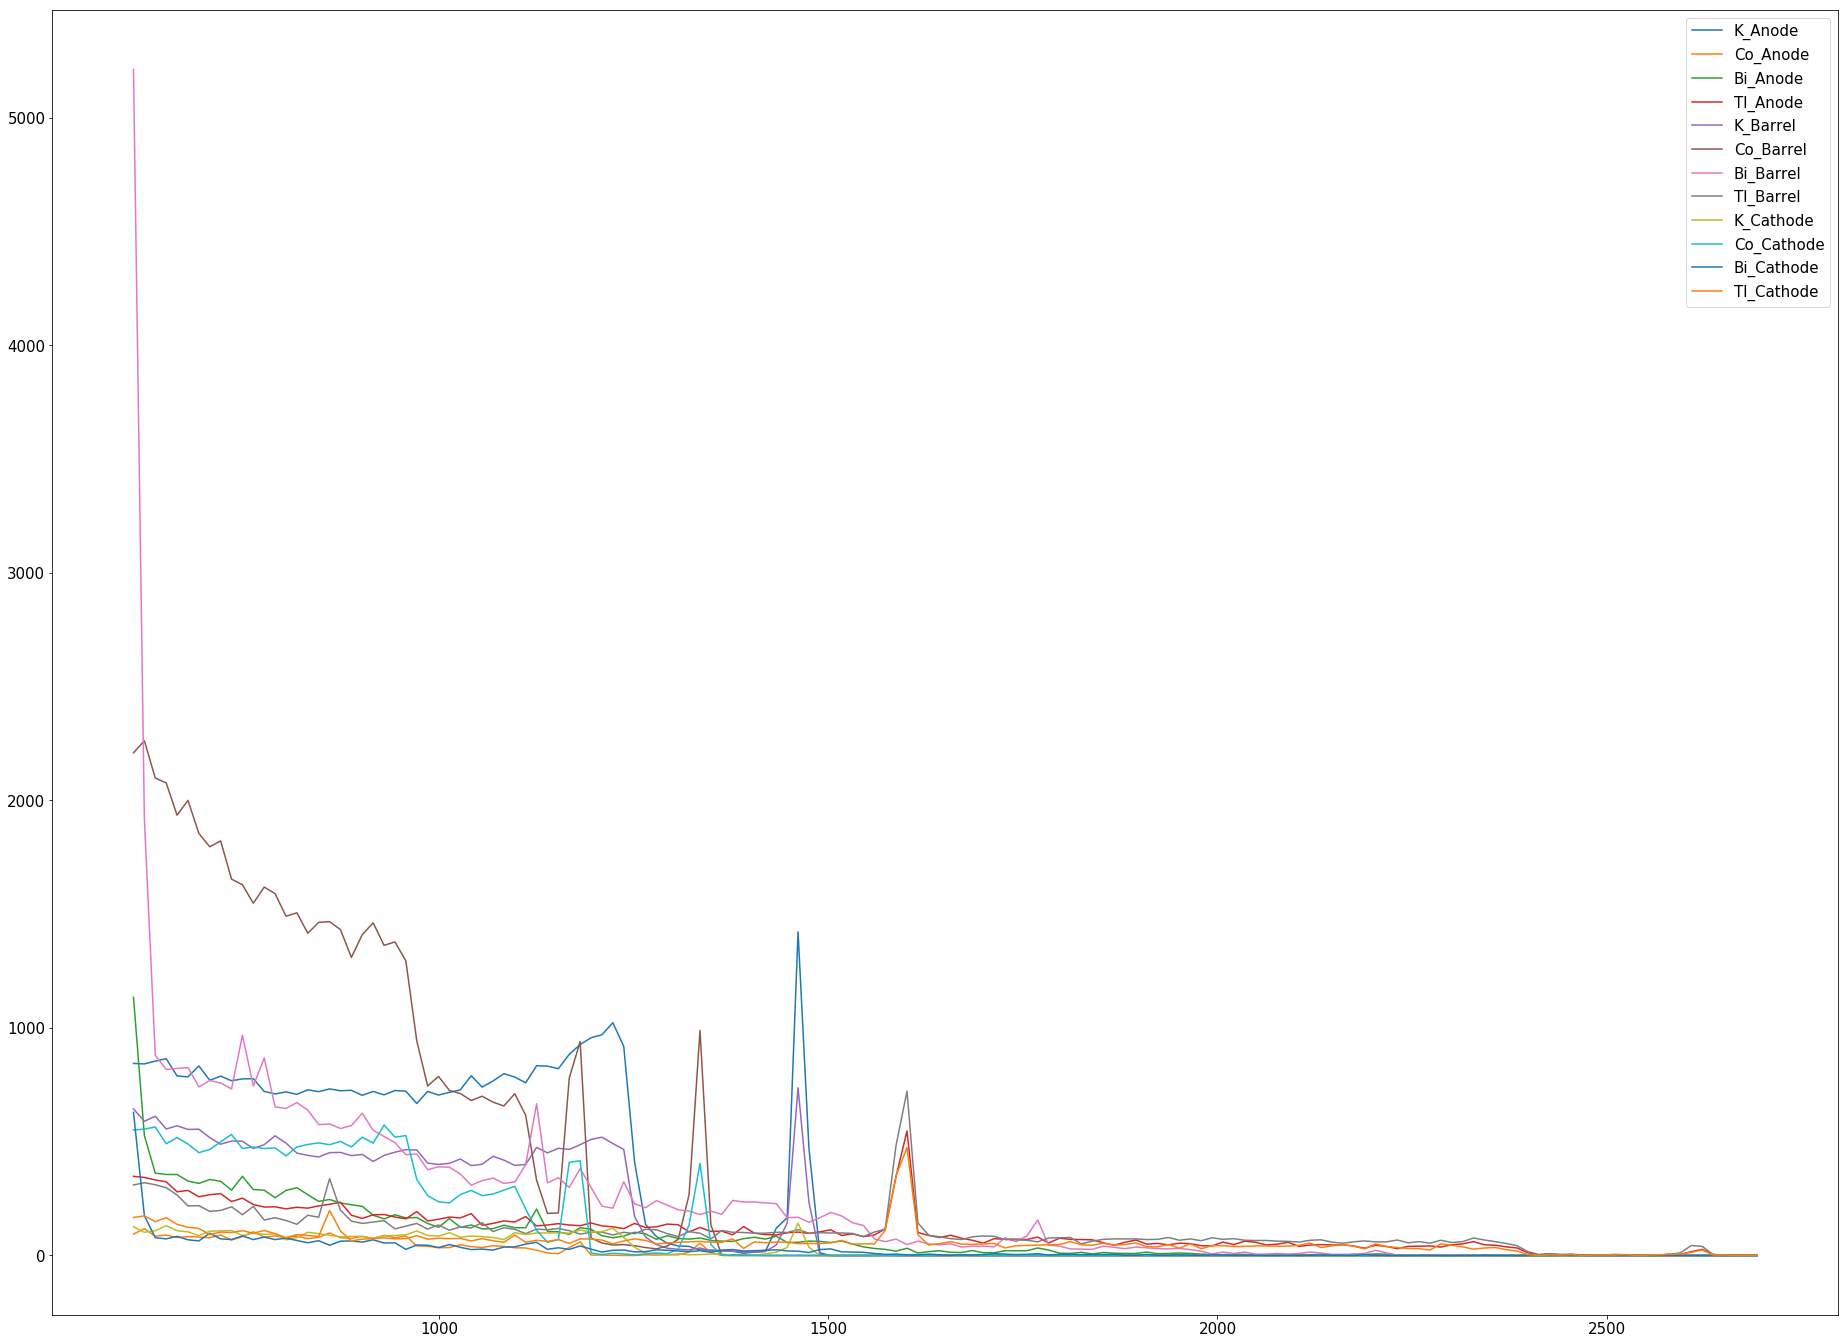

In [9]:
i = 0
for region in regions:
        for isotope in isotopes:
            h_ = histograms['E'][i]
            plt.plot(h_.bins, h_.hist, label=name[i])
            i += 1
plt.legend()

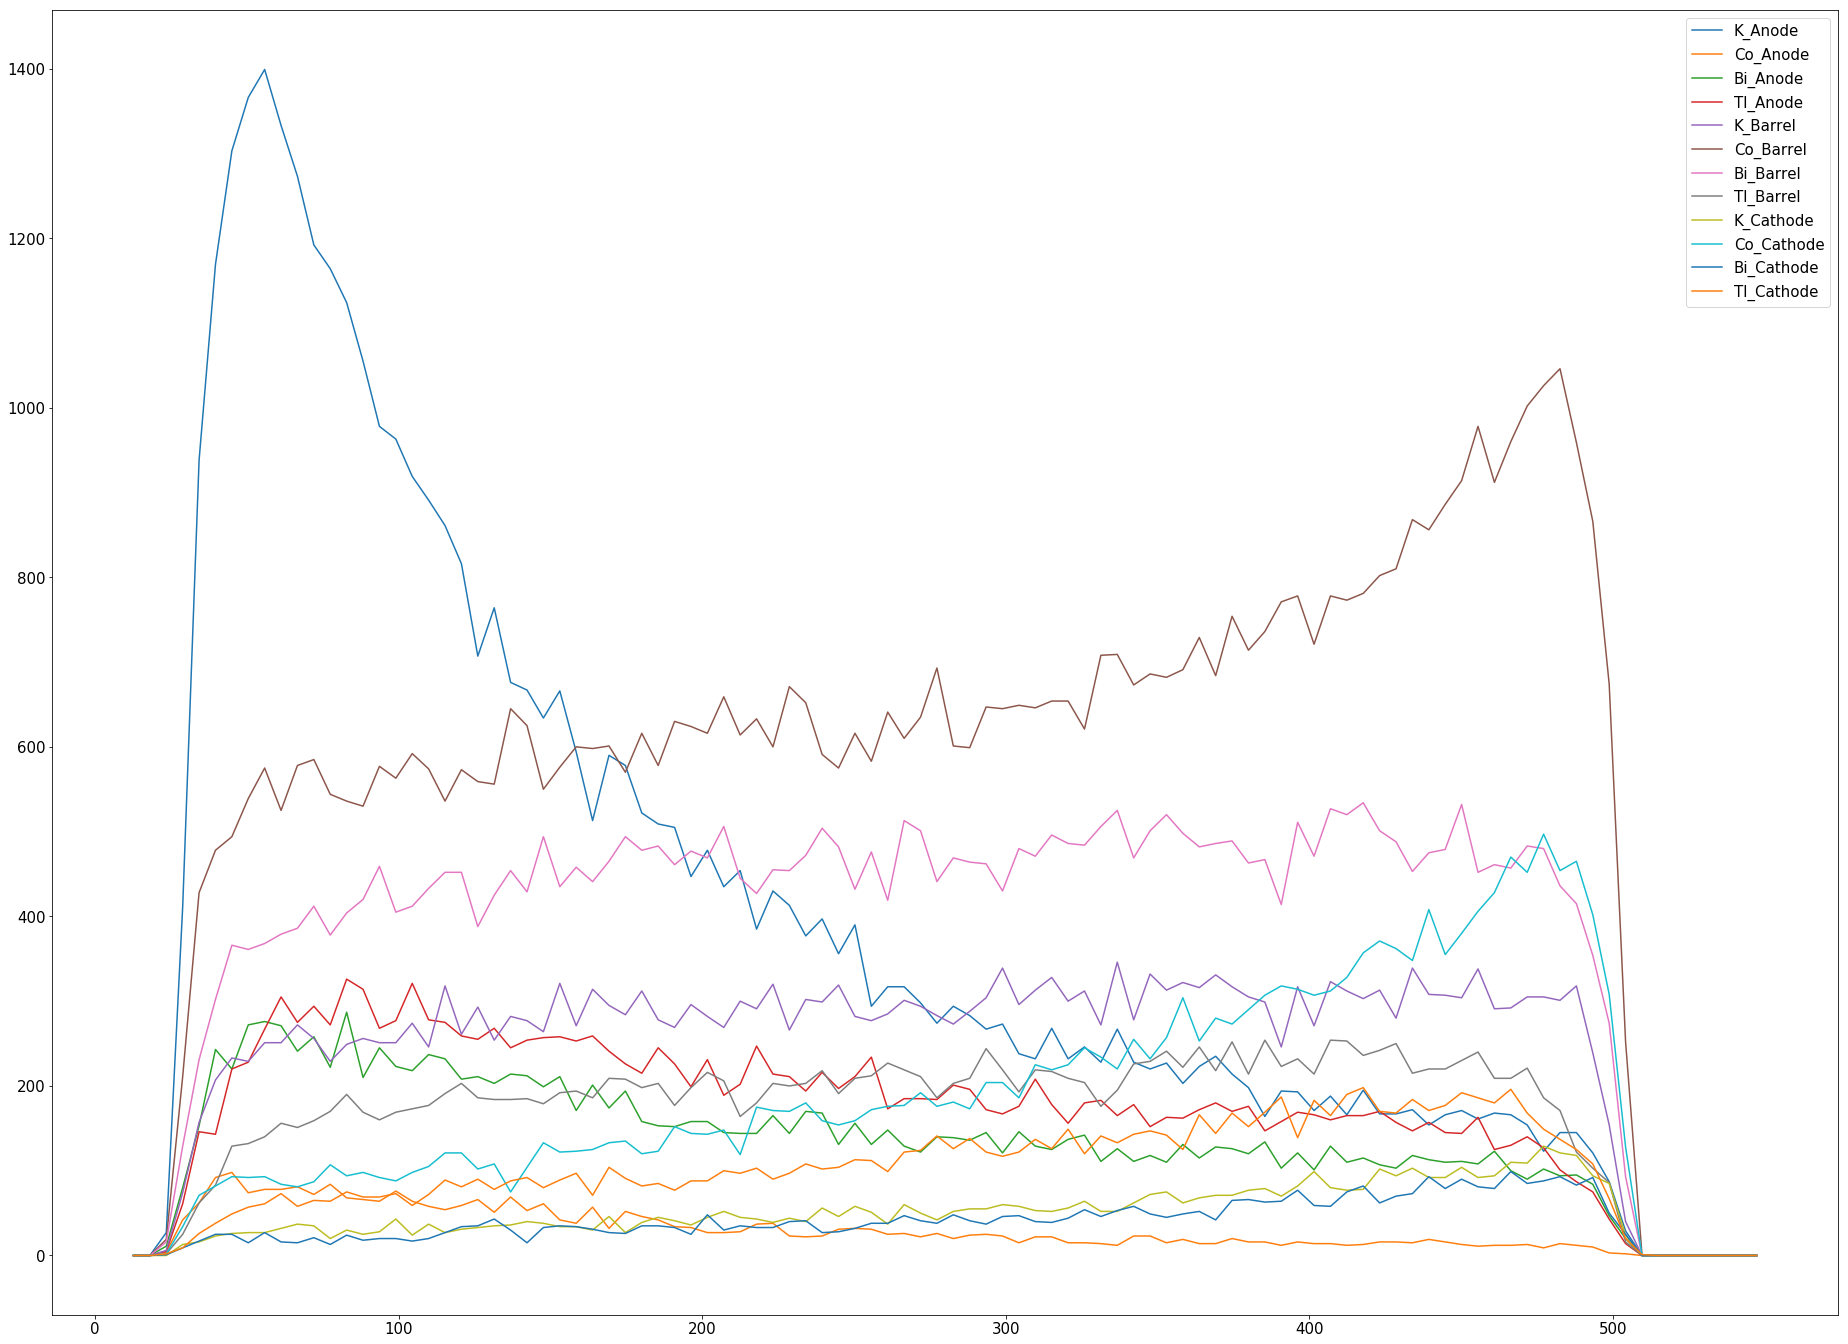

In [10]:
i = 0
for region in regions:
        for isotope in isotopes:
            h_ = histograms['z'][i]
            plt.plot(h_.bins, h_.hist, label=name[i])
            i += 1
plt.legend()

In [11]:
pdfs = {'E':[], 'z':[]}

interpol = 'cubic'

pdfs['E'] = [PDF(h_, interpolation=interpol) for h_ in histograms['E']]
pdfs['z'] = [PDF(h_, interpolation=interpol) for h_ in histograms['z']]

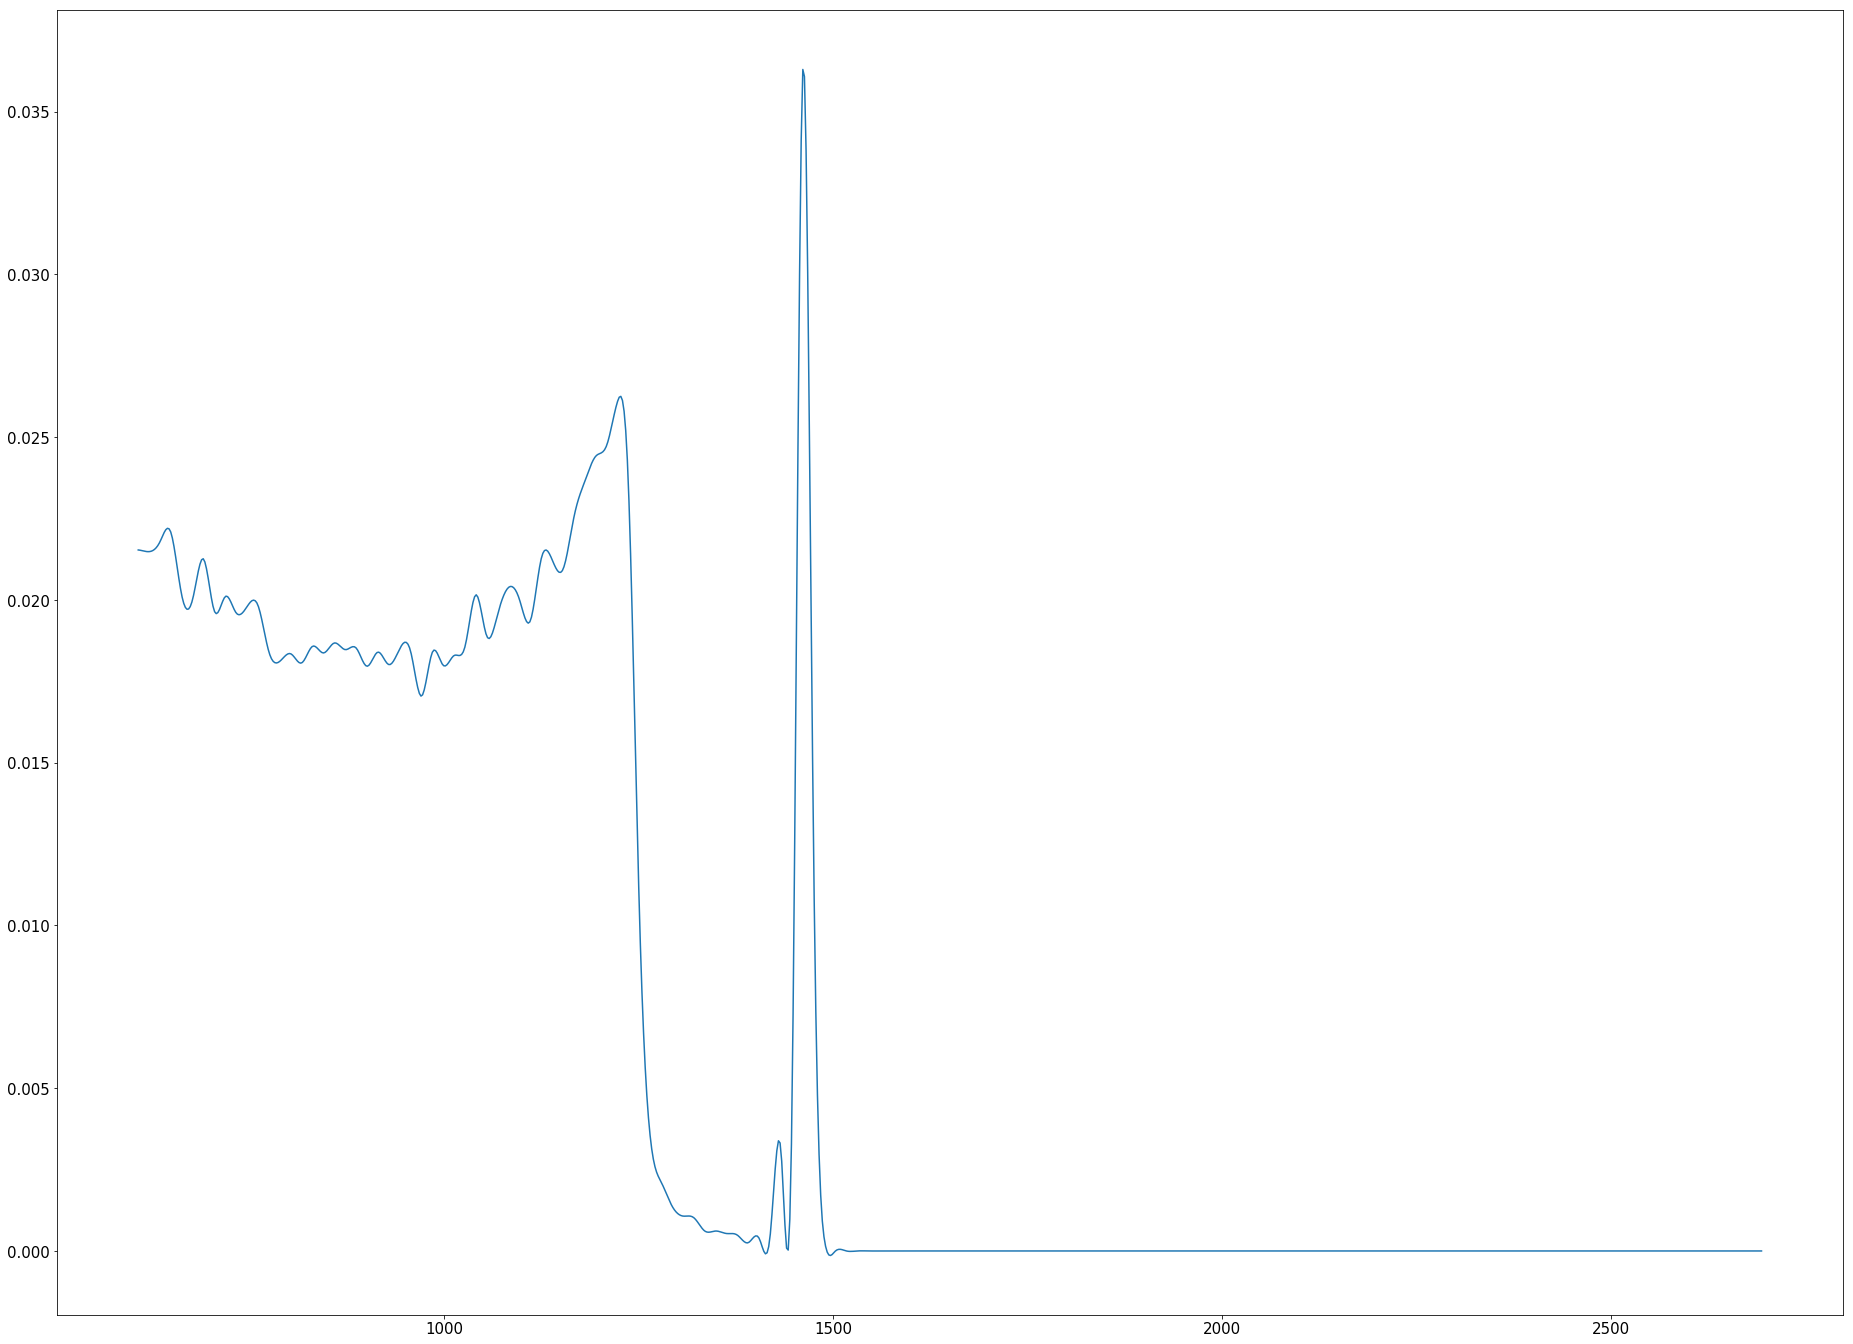

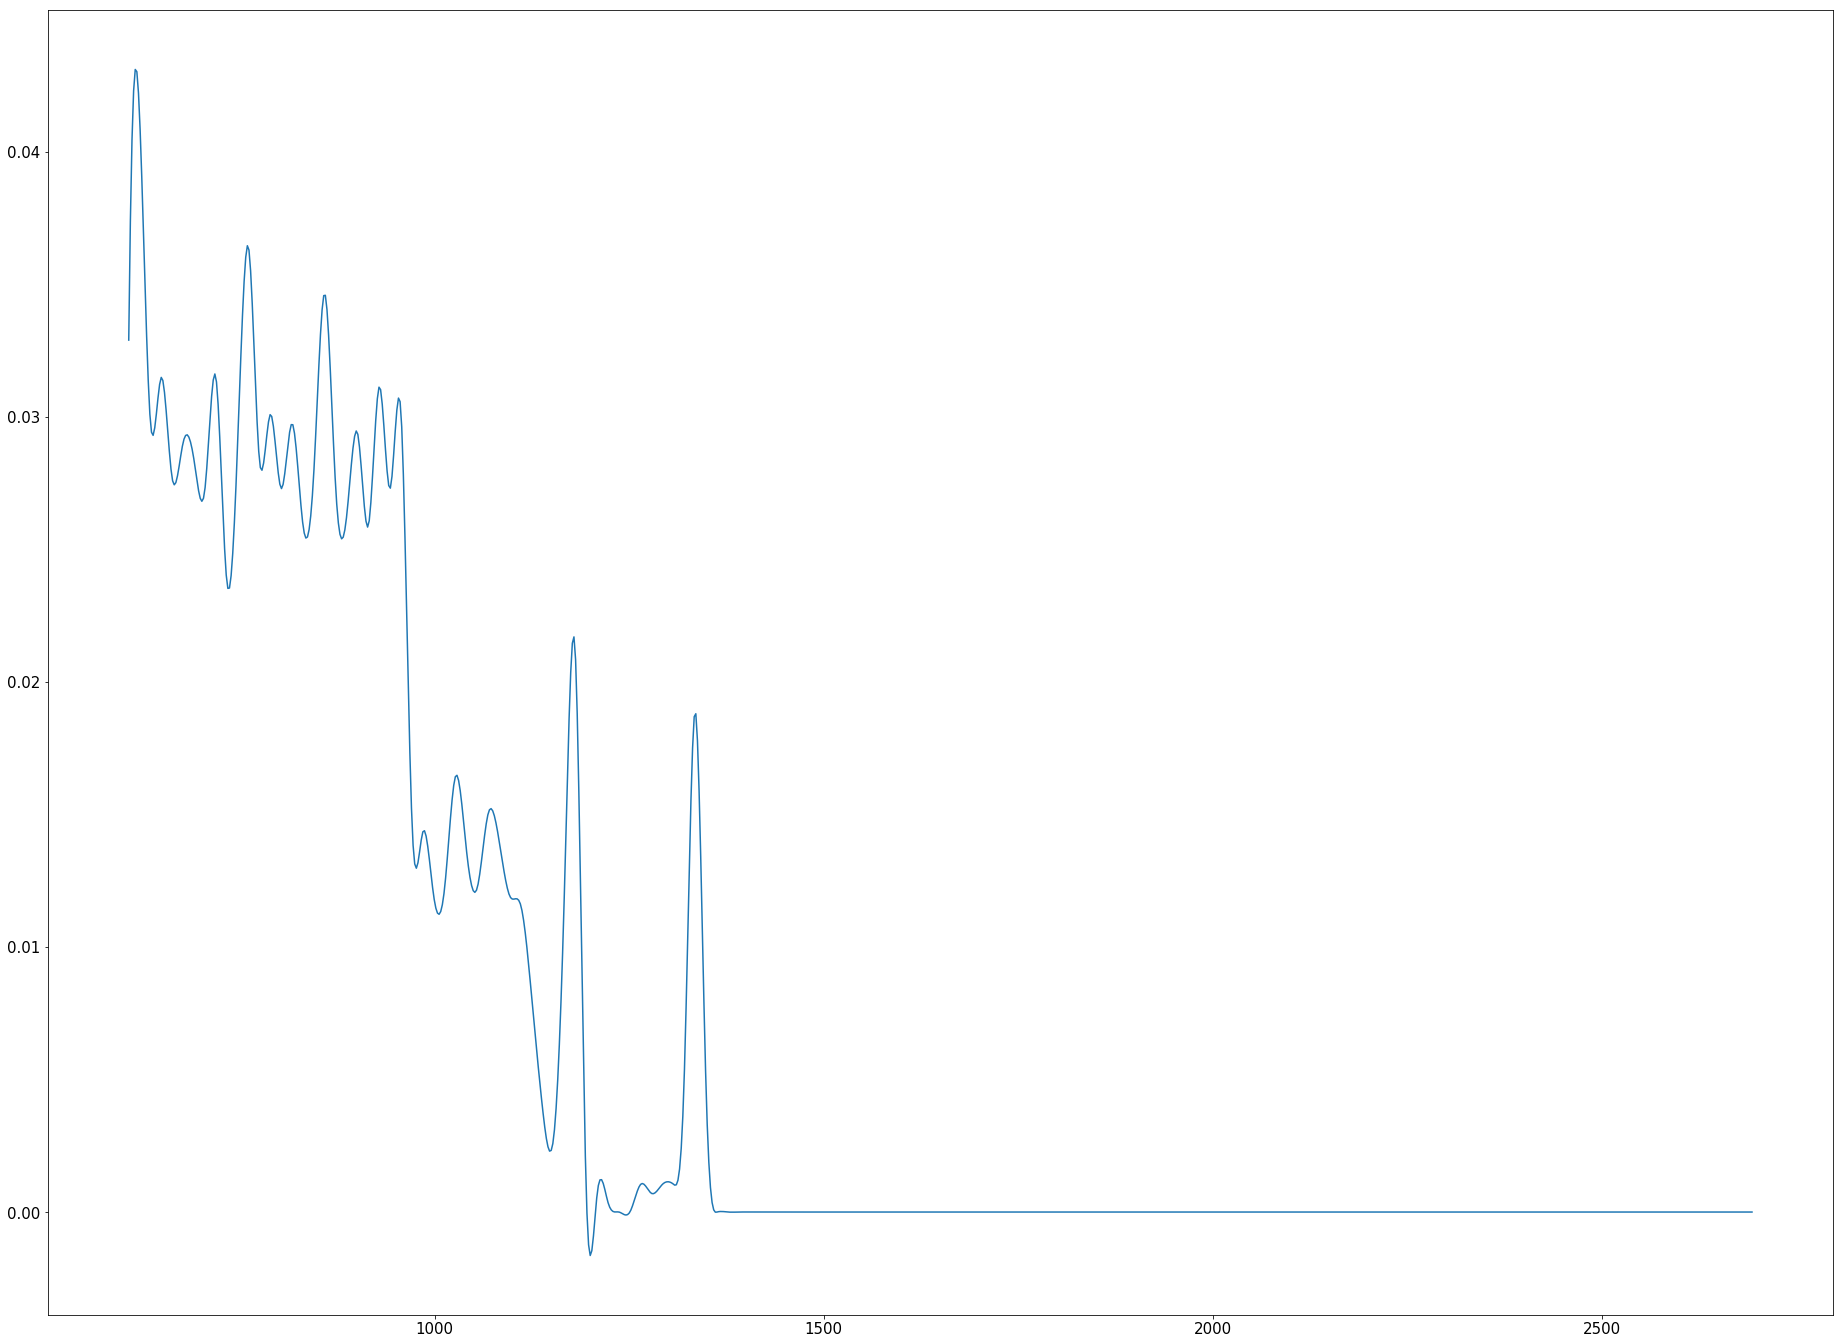

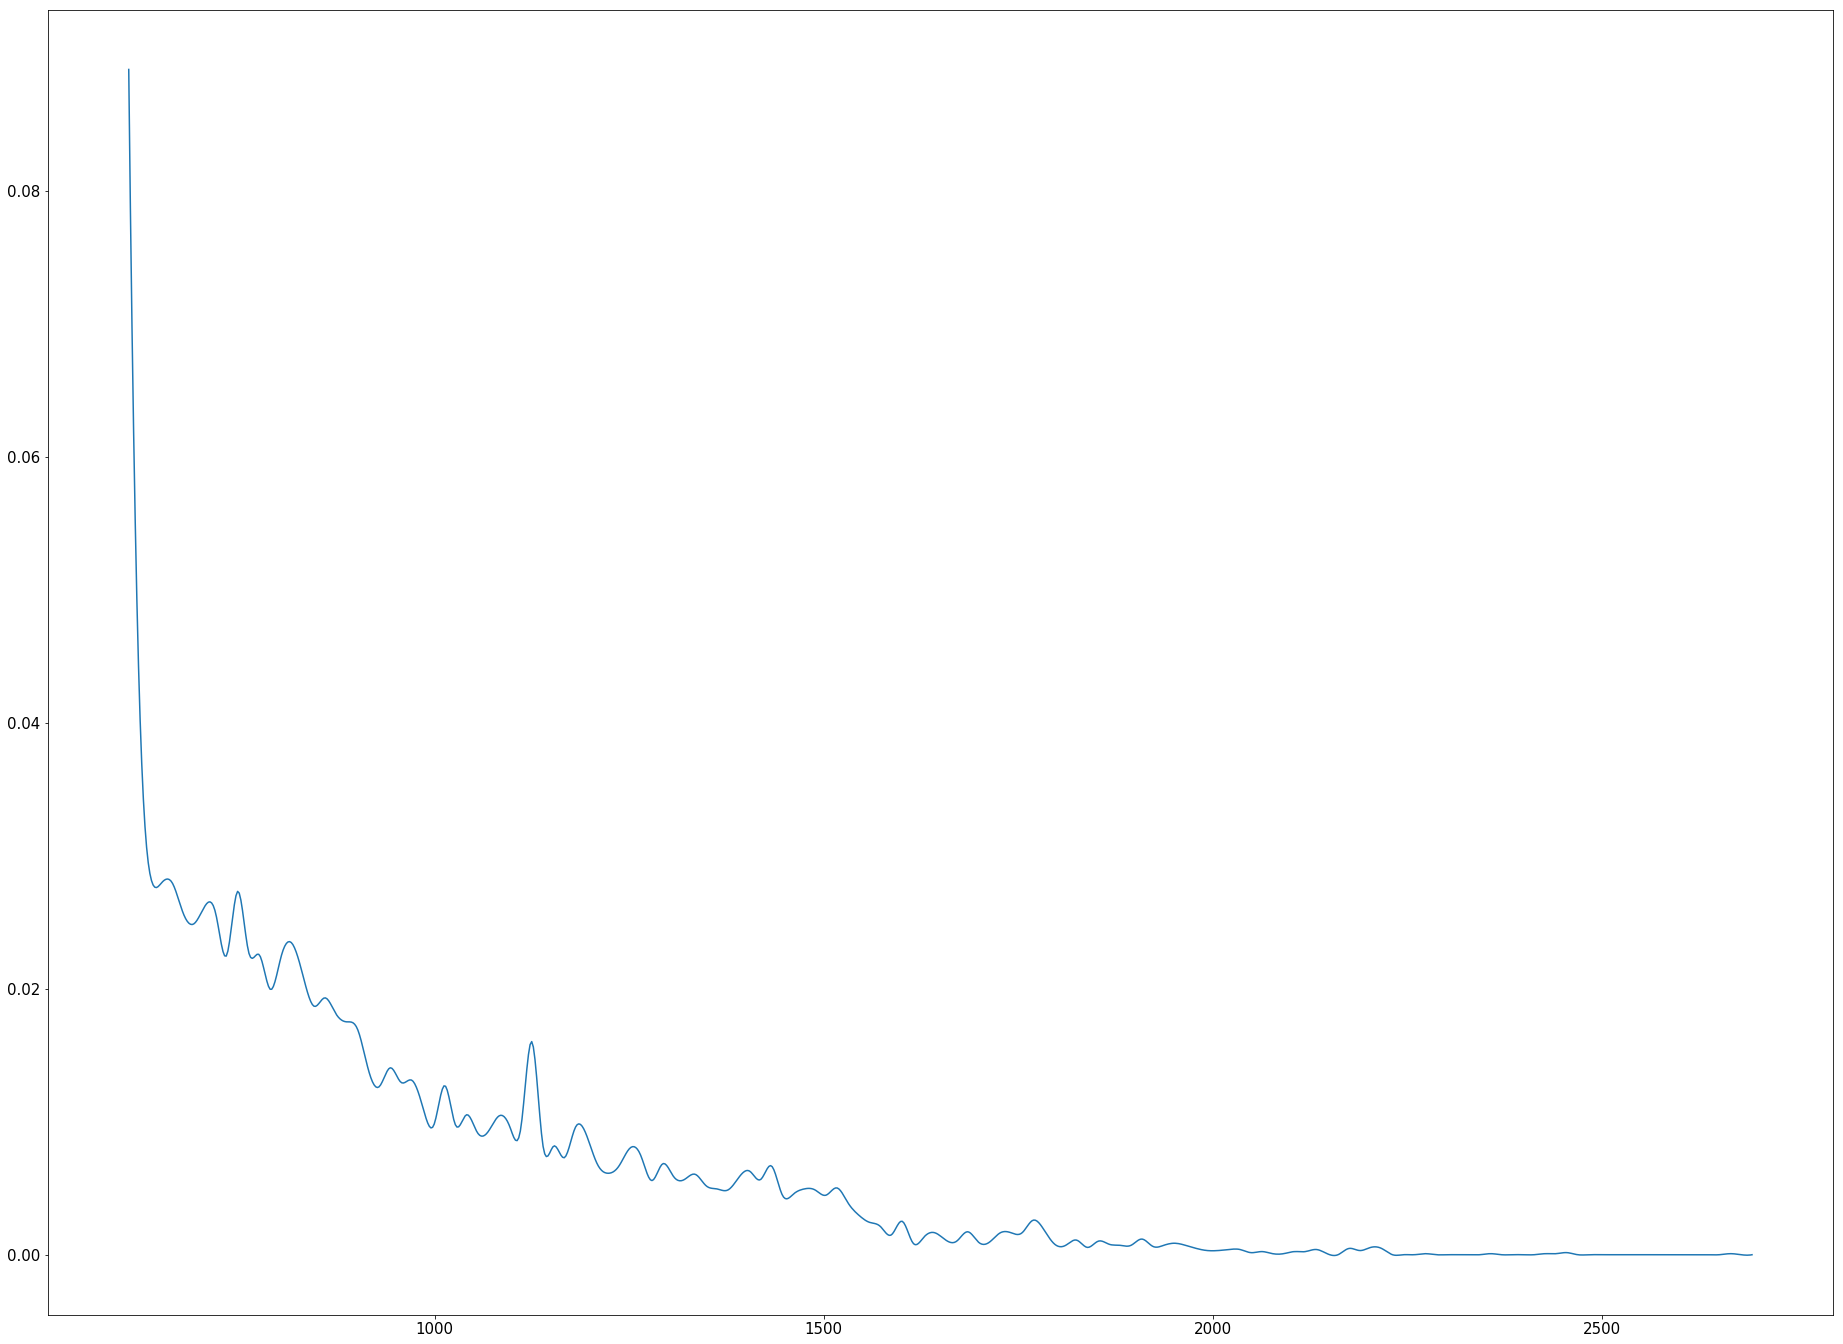

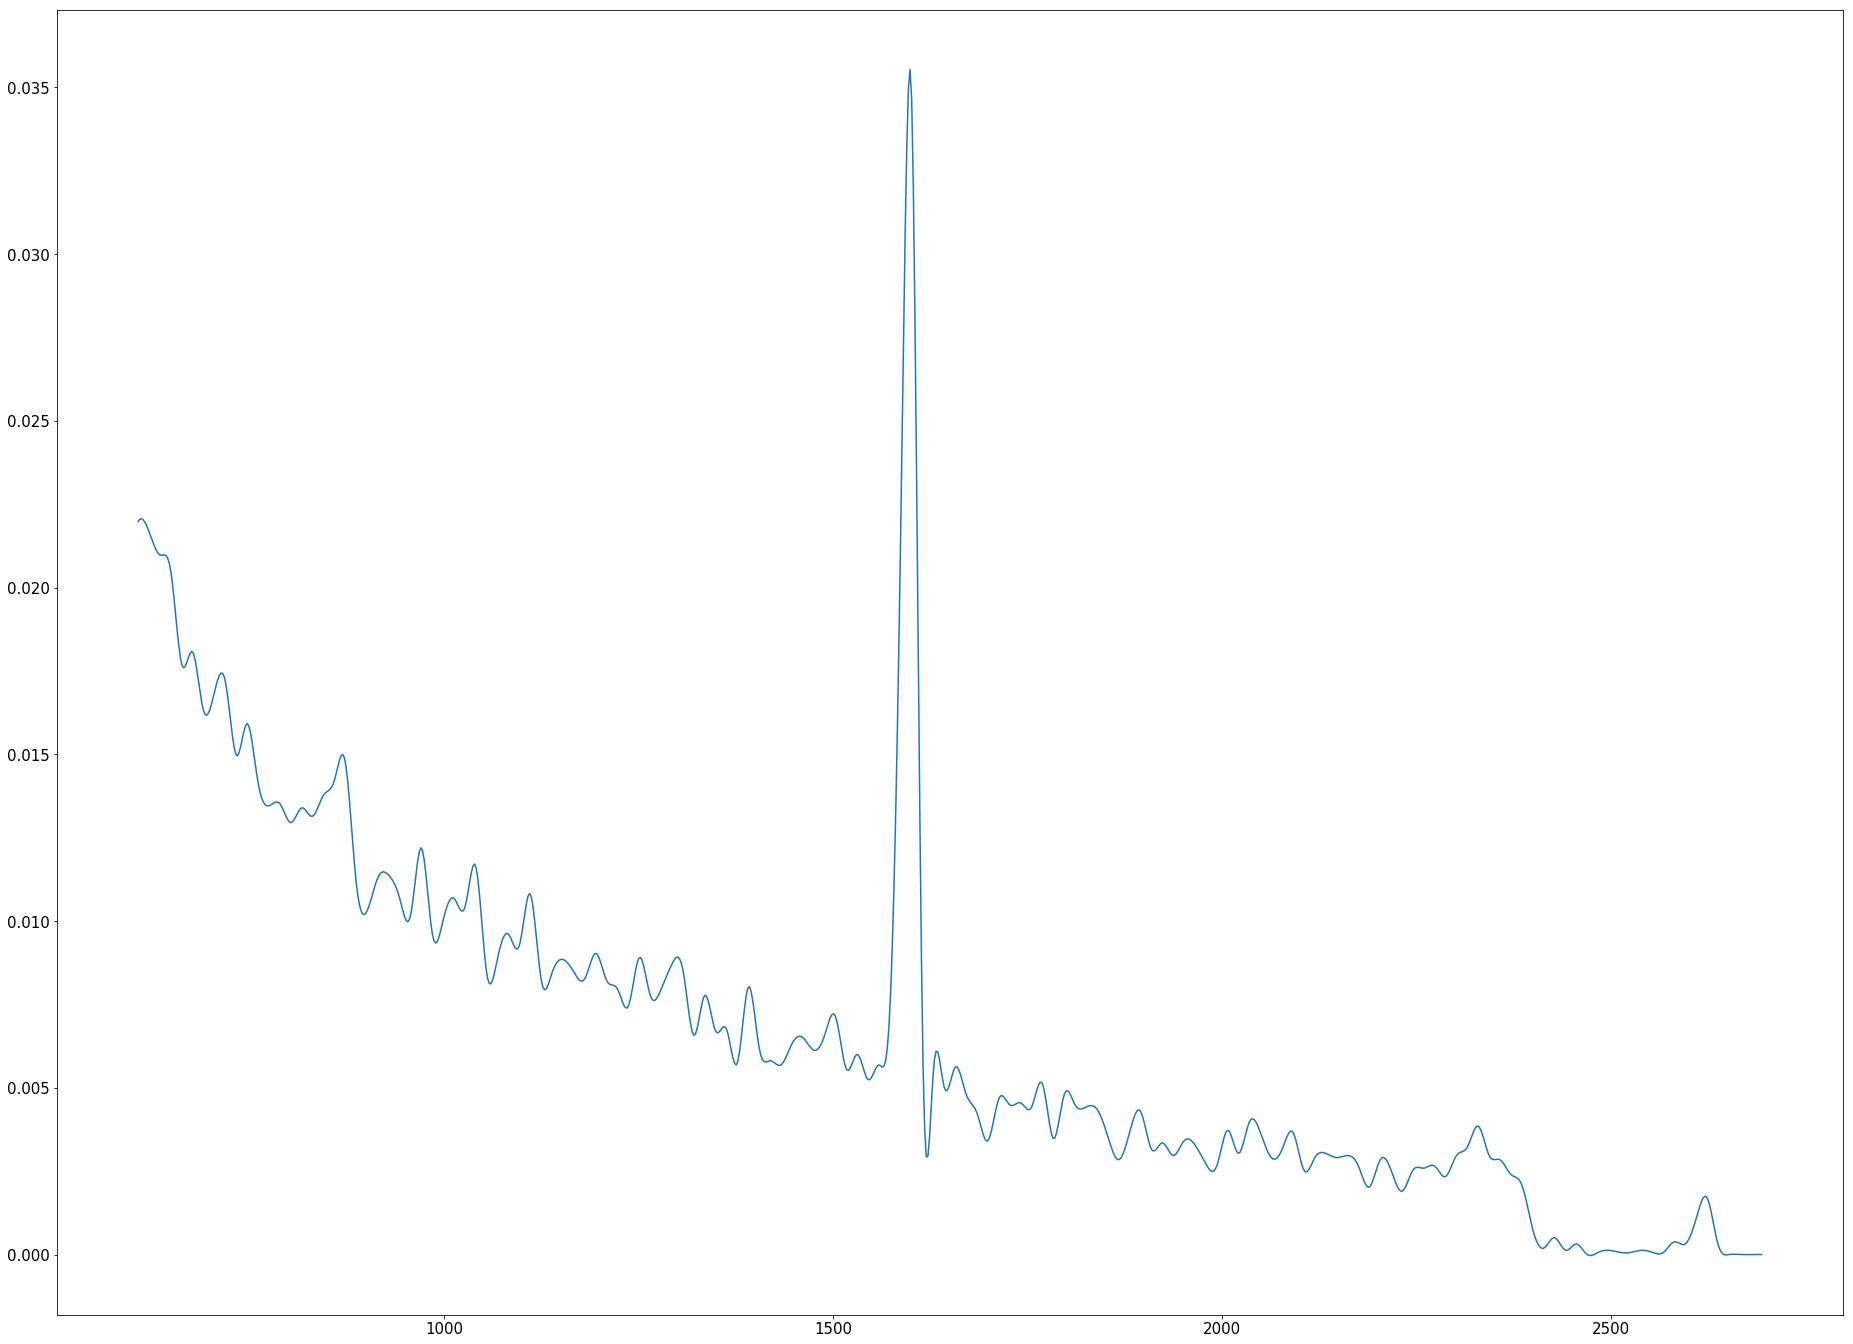

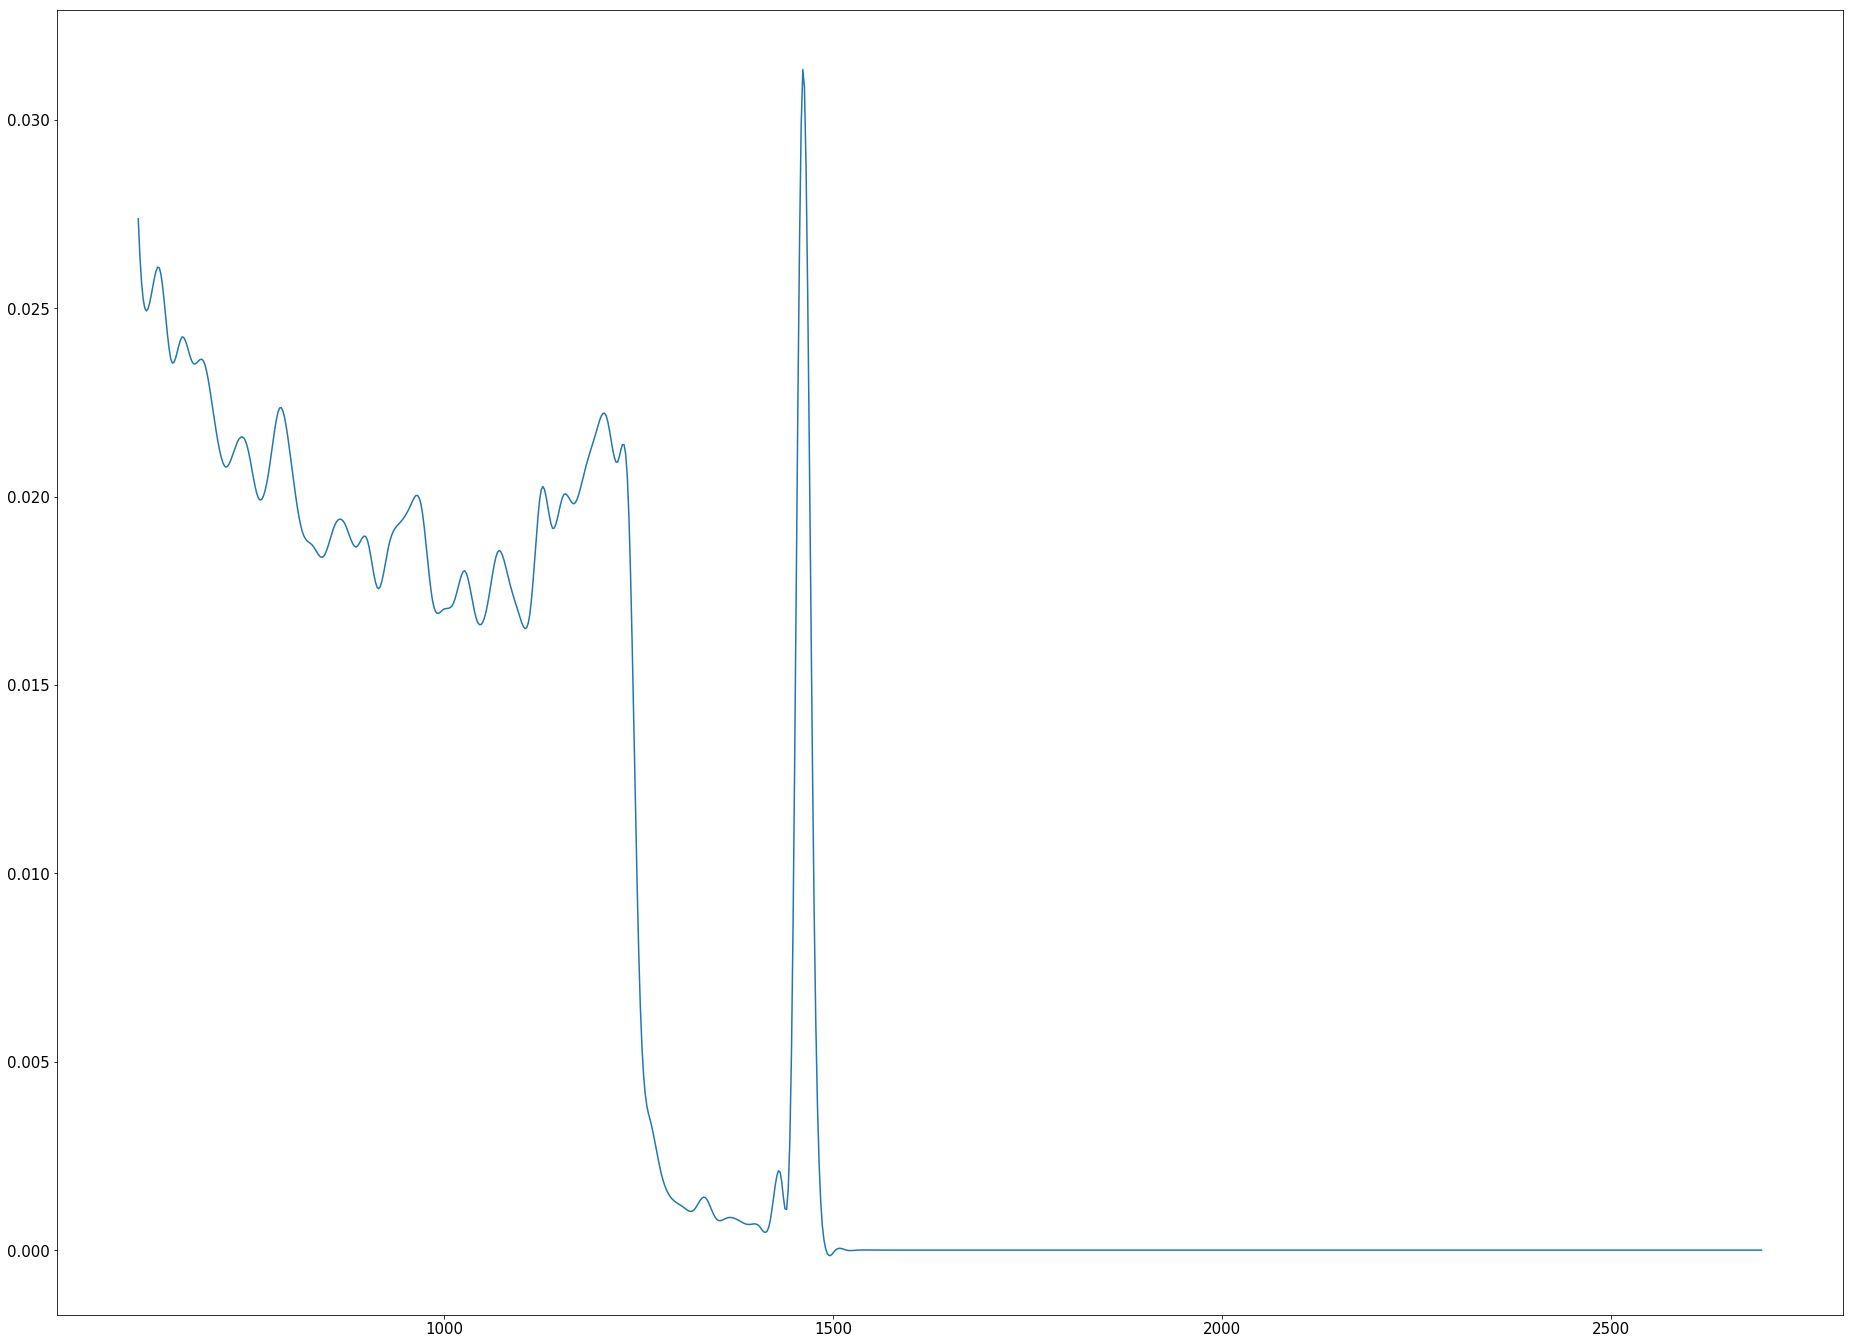

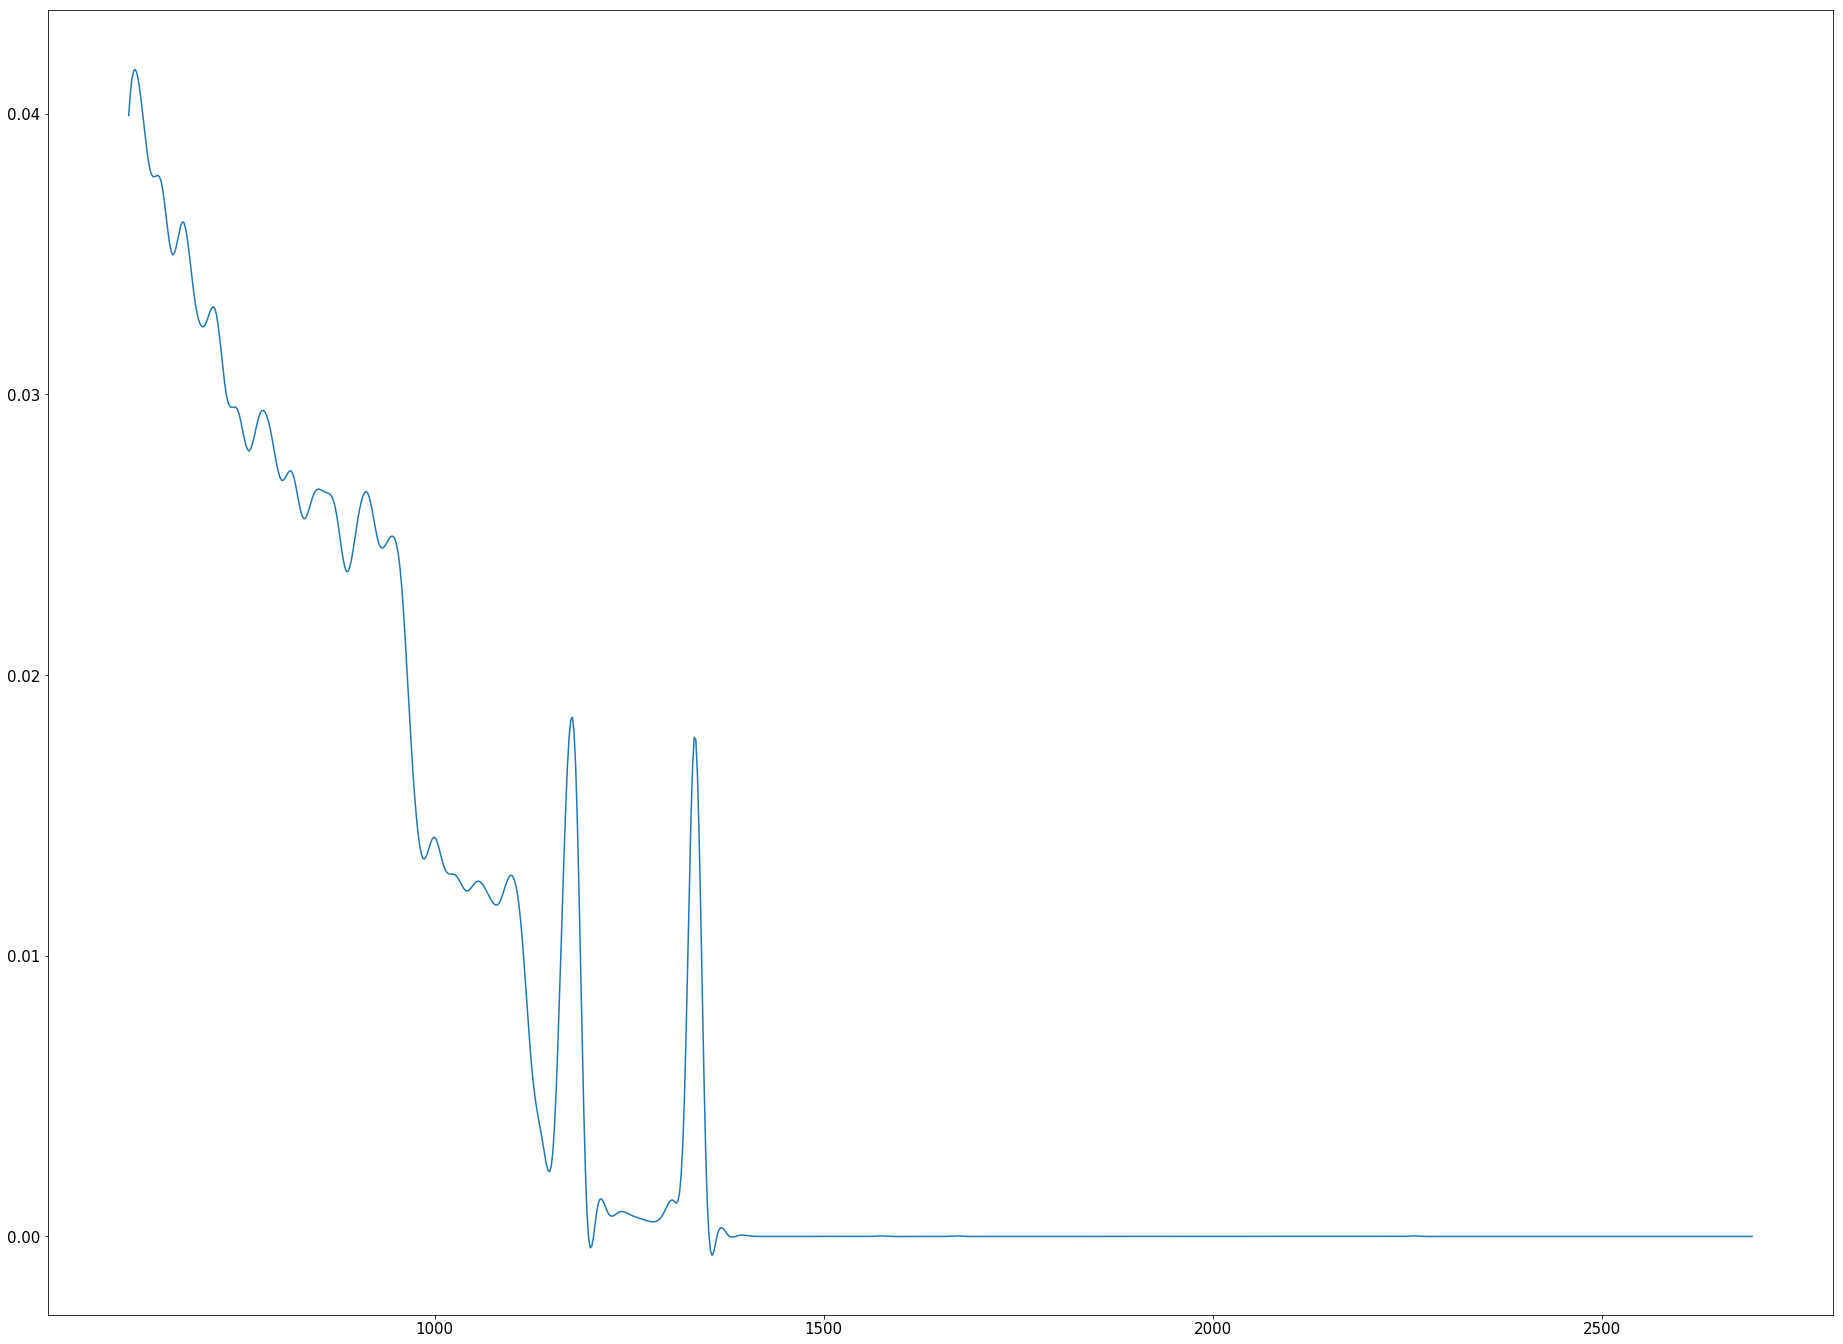

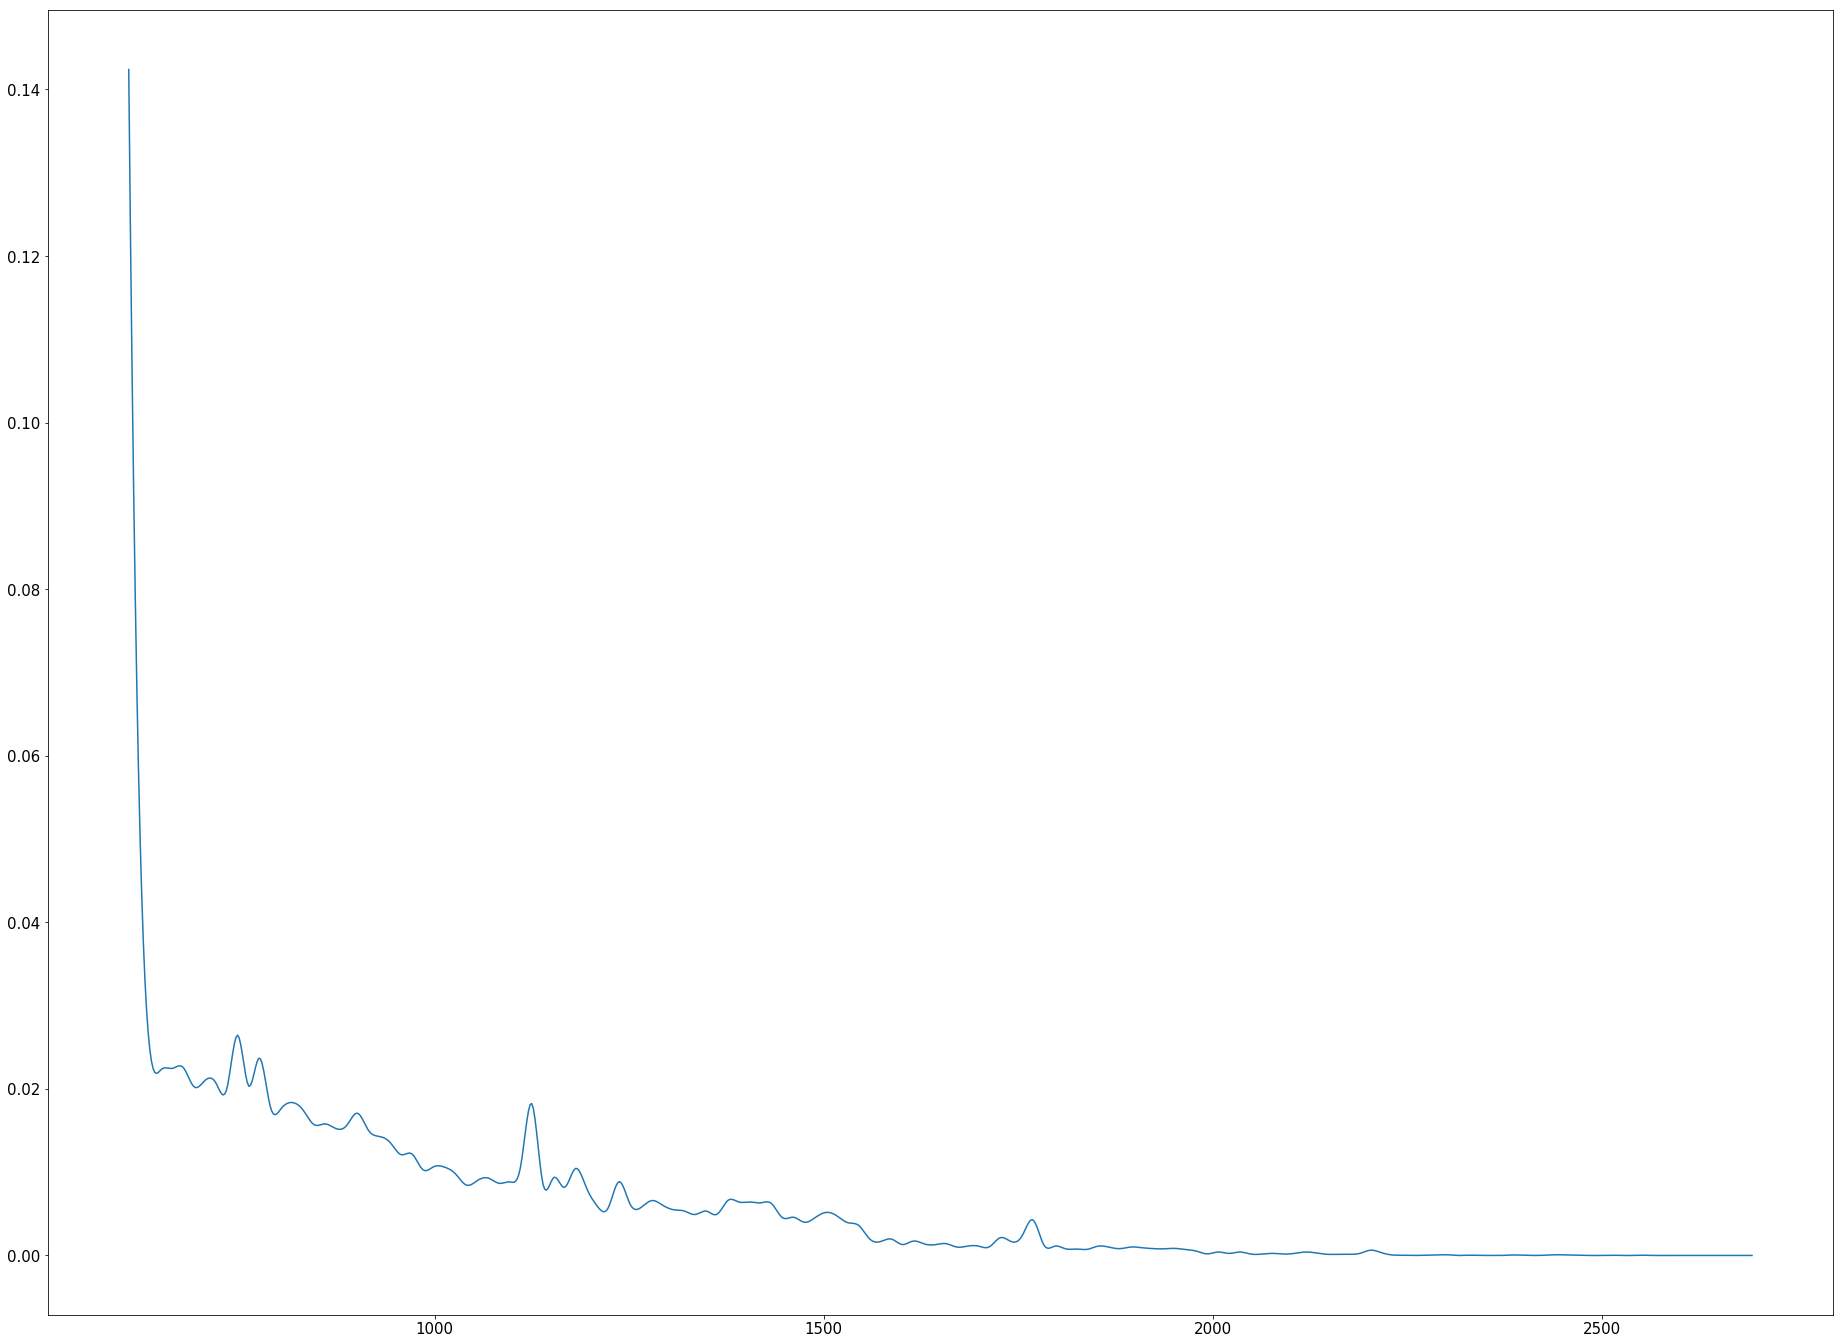

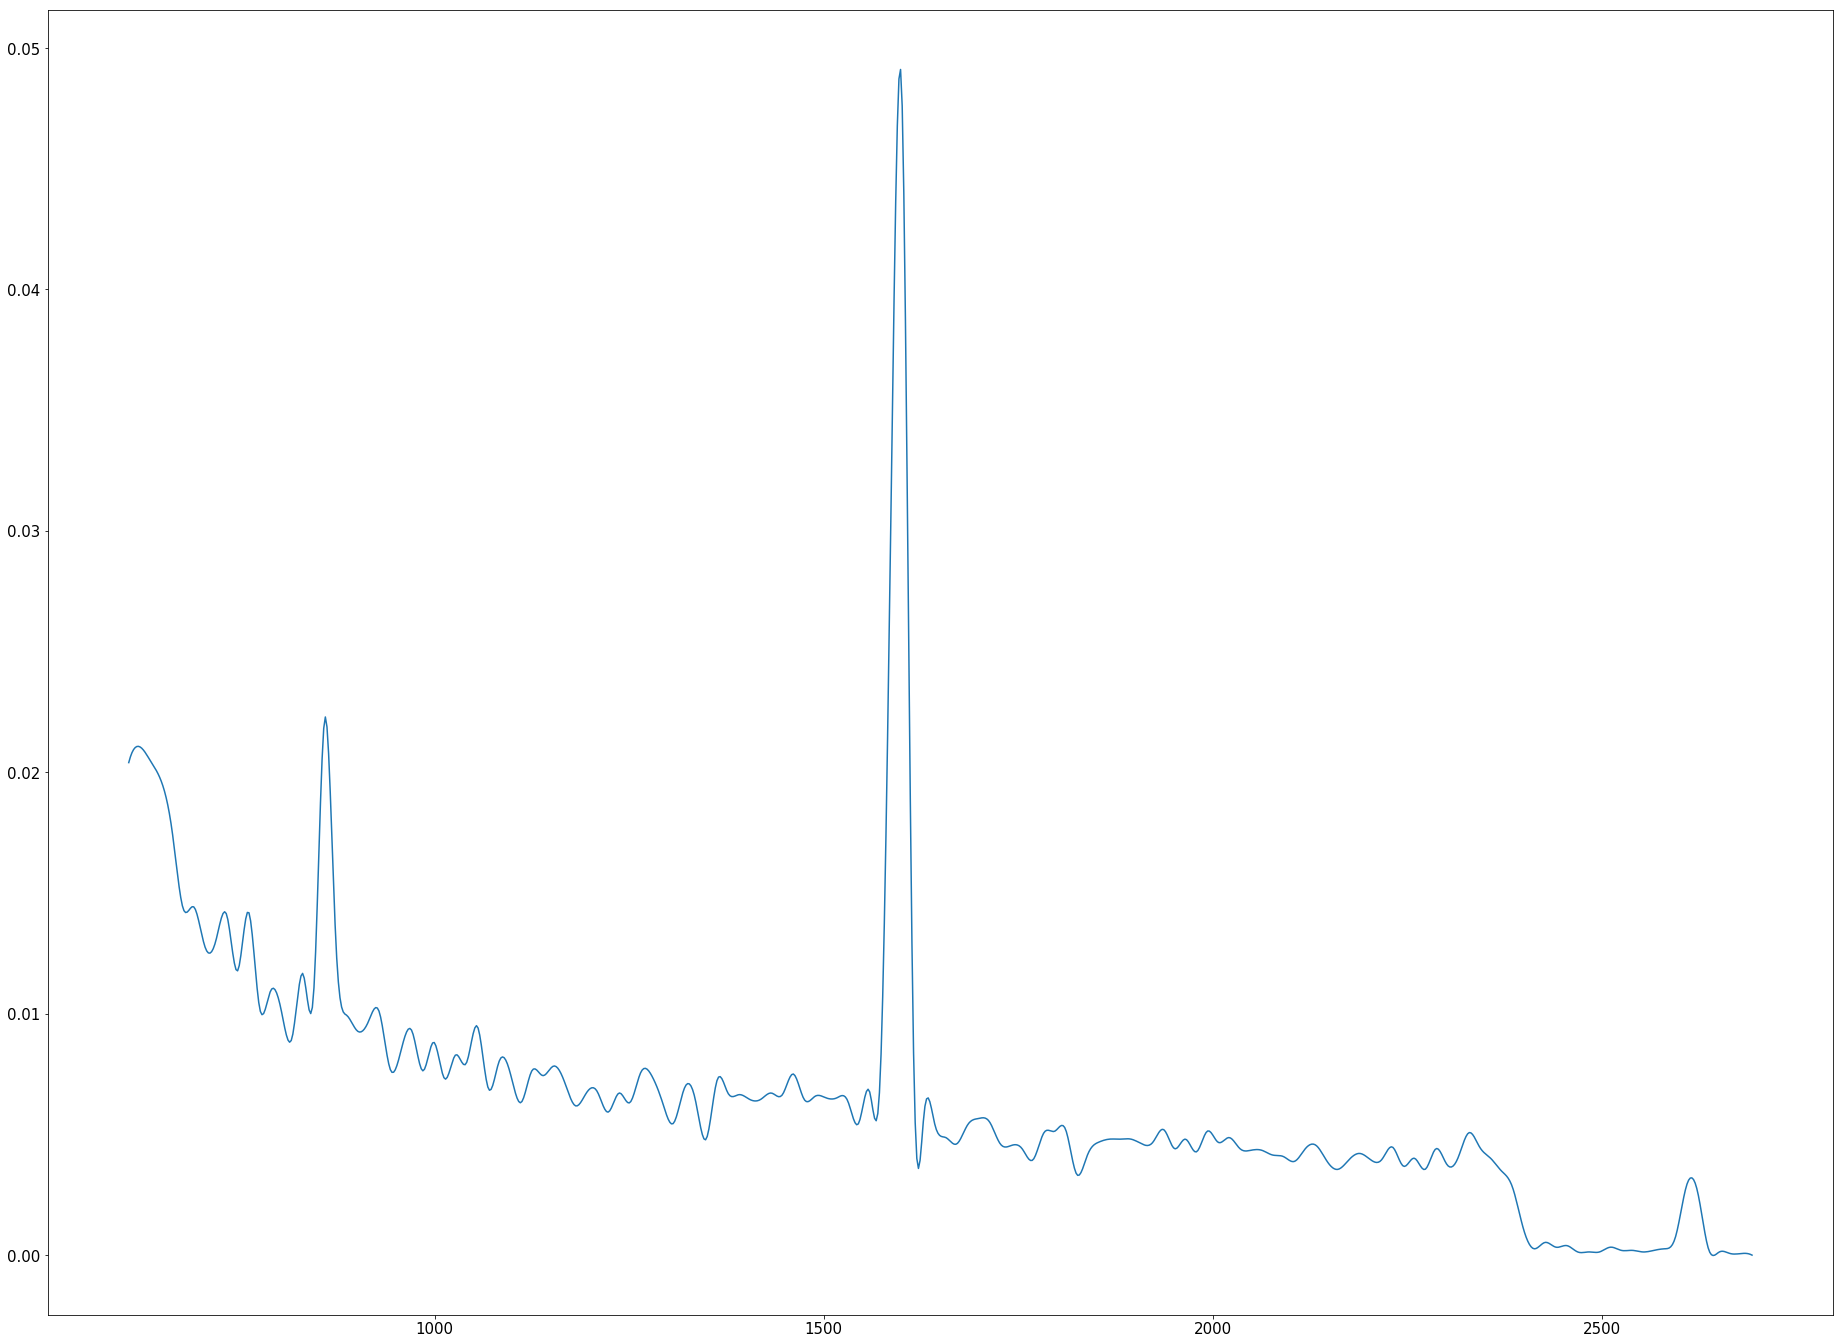

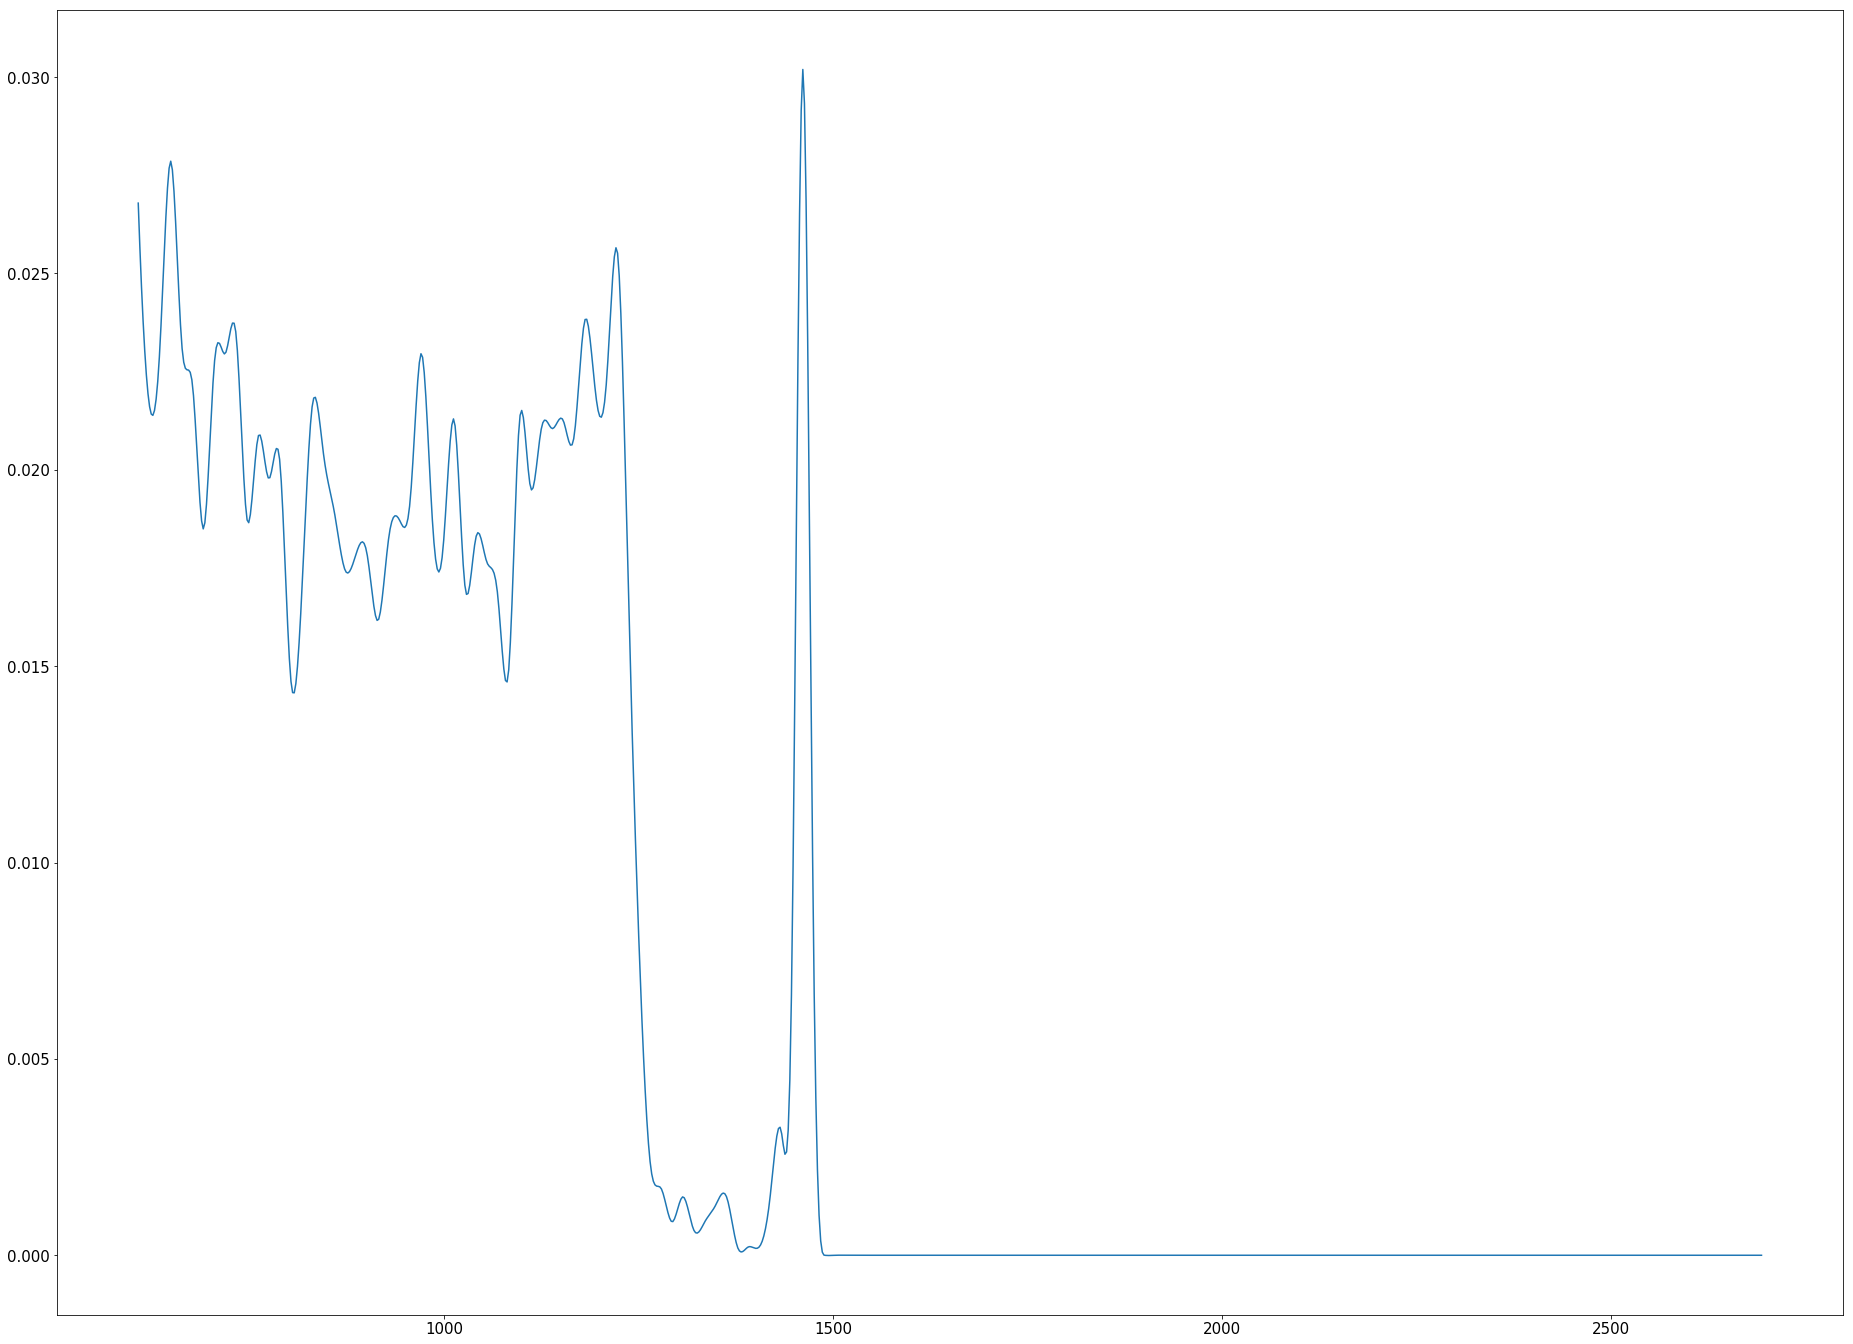

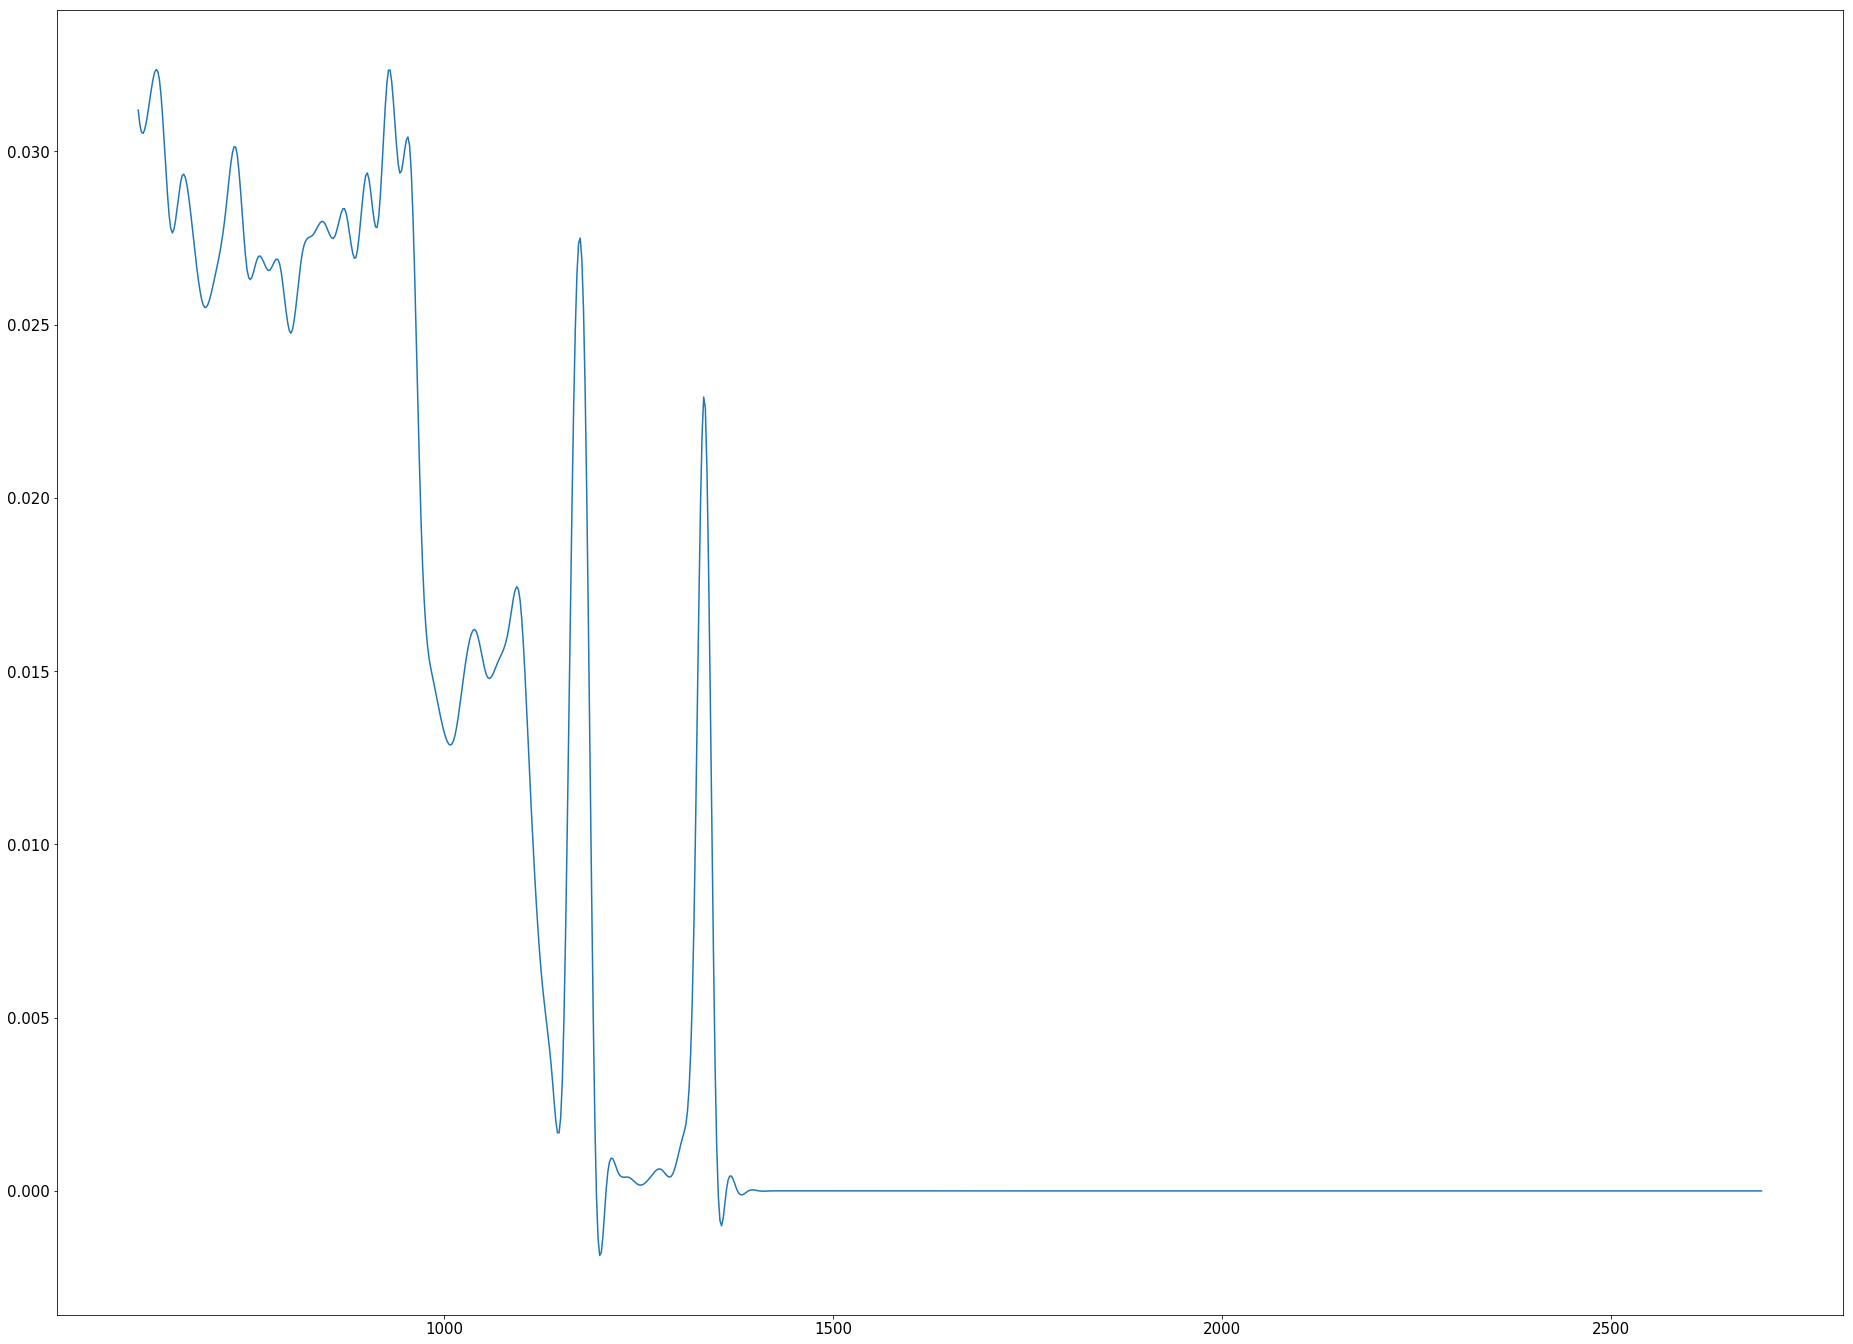

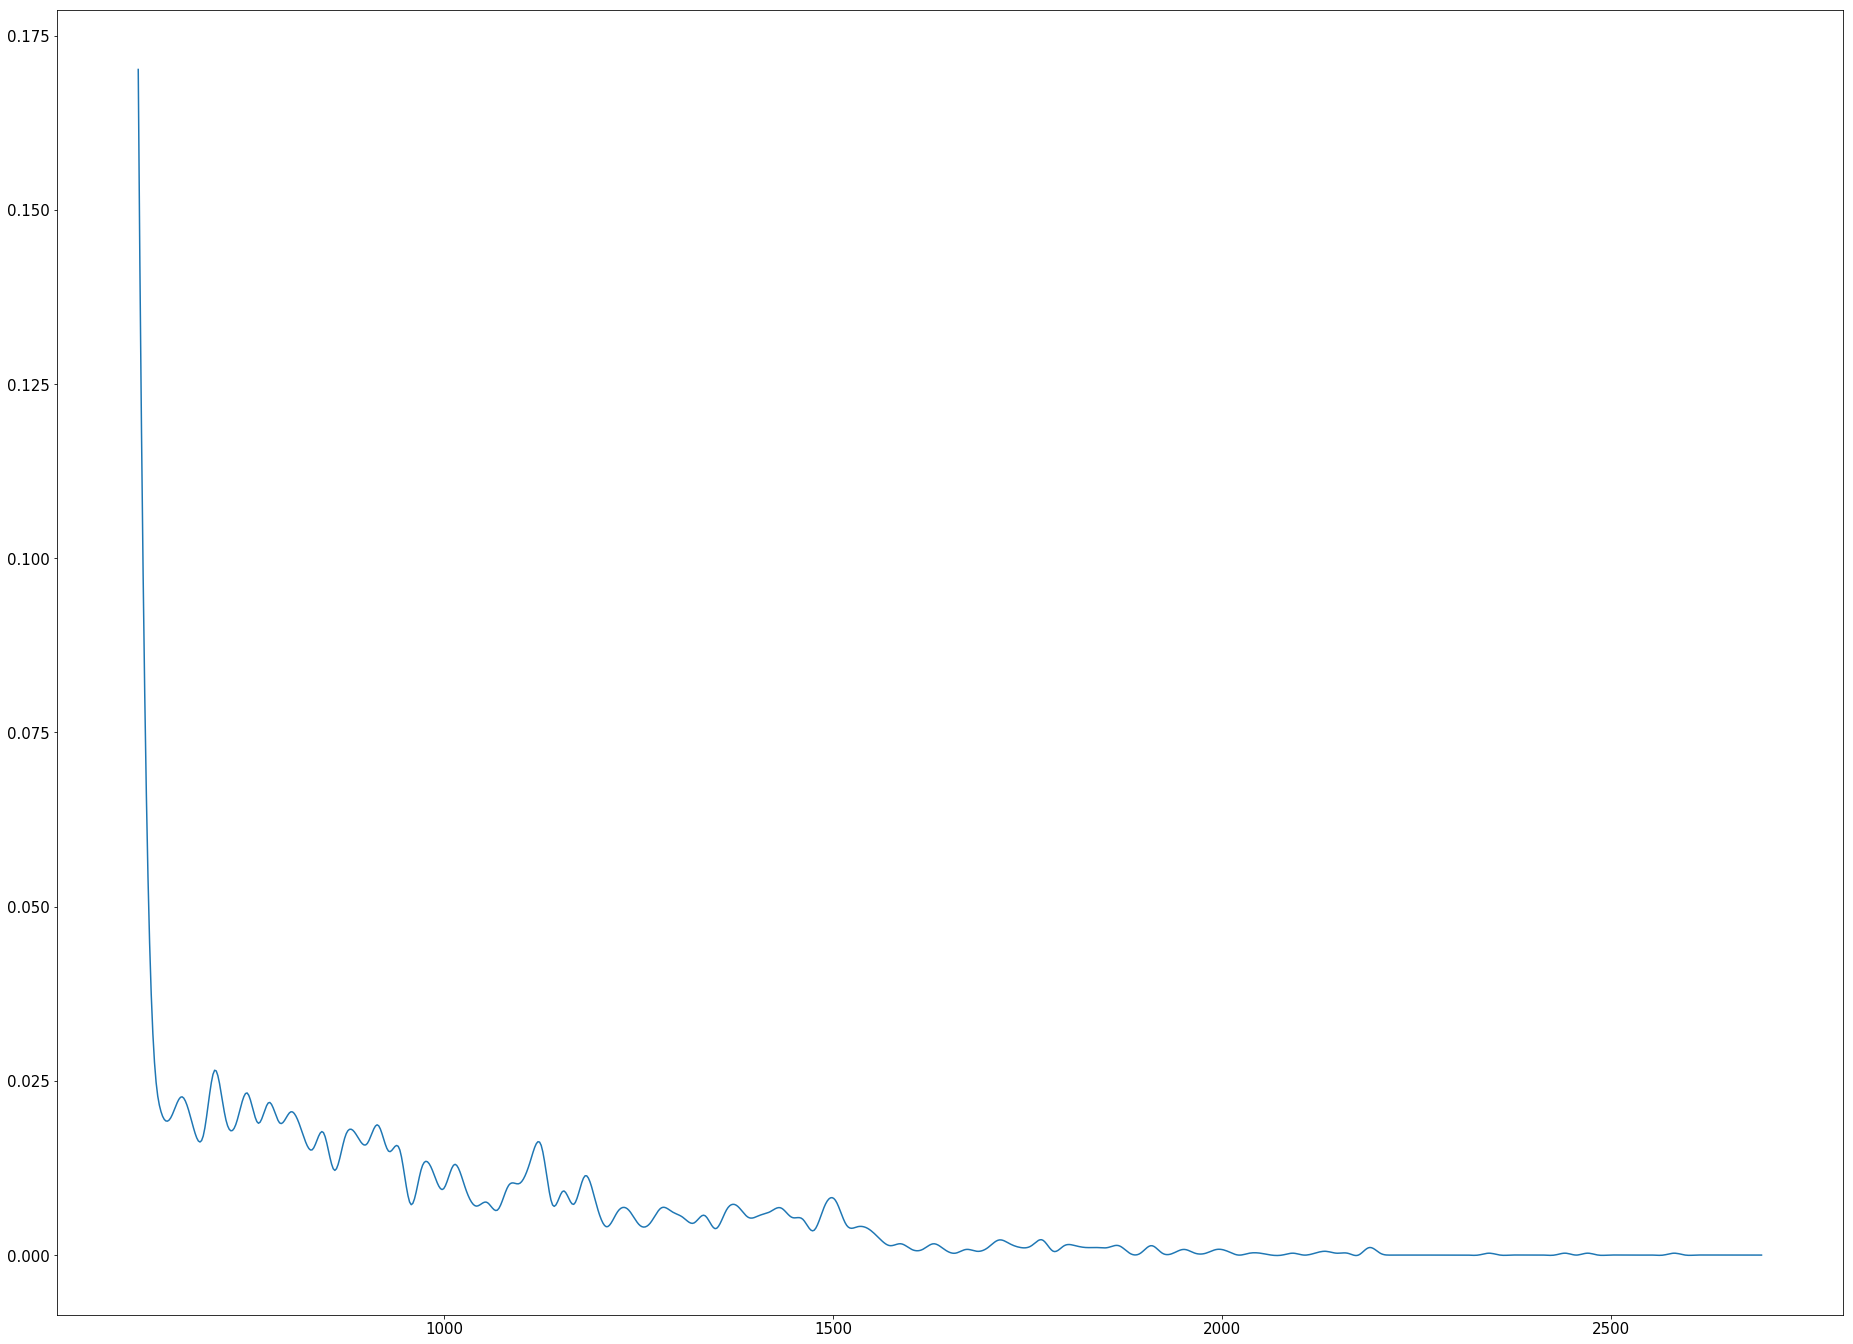

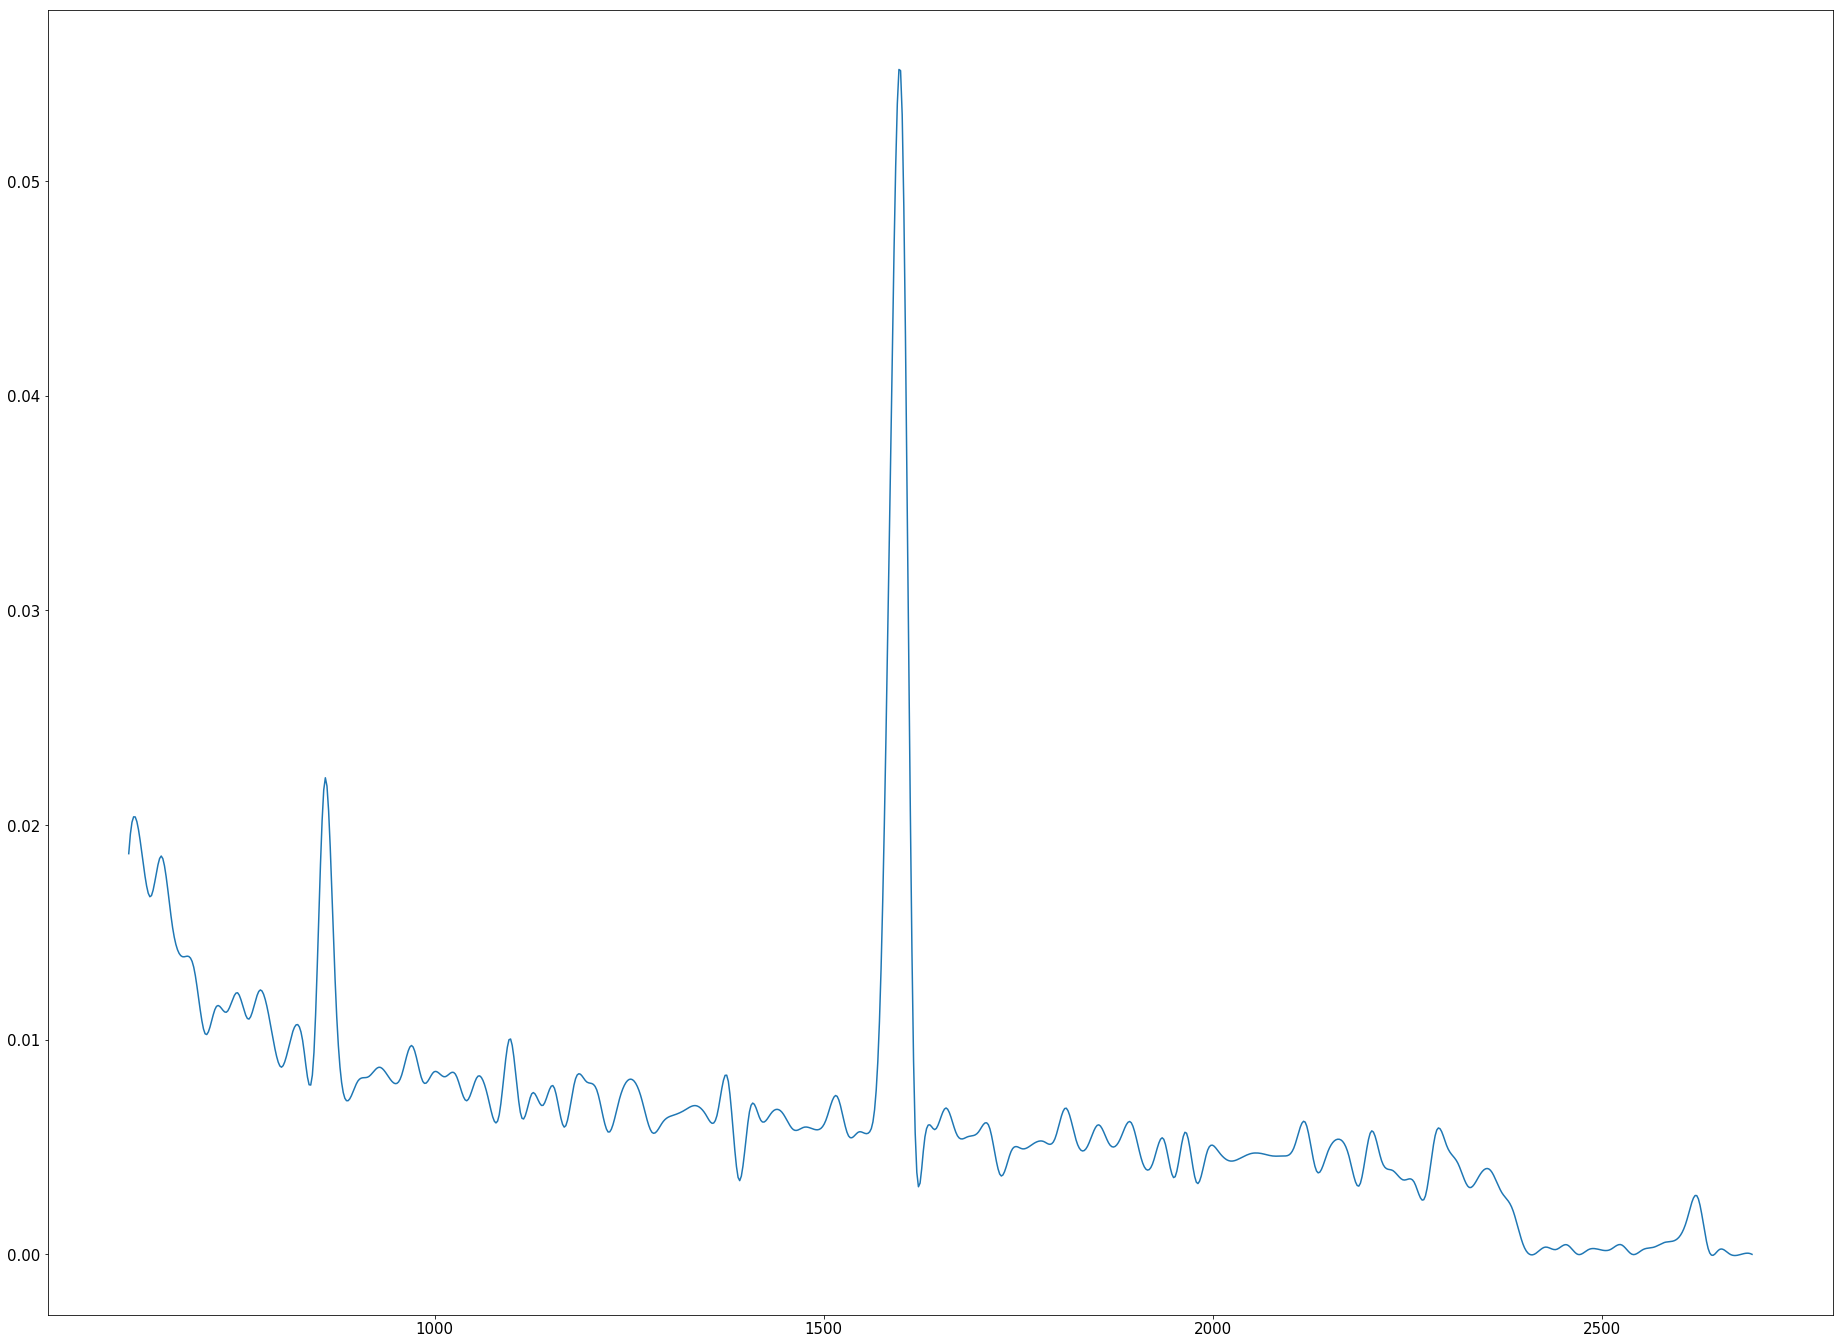

In [12]:
Ep = np.linspace(histograms['E'][0].bins[0],histograms['E'][0].bins[-1],1000)

for pdf in pdfs['E']:
    
    plt.figure()
    y = pdf.pdf(Ep)
    plt.plot(Ep, y)
    plt.show()

In [13]:
x_dict = {'E': histograms['E'][0].bins , 'z': histograms['z'][0].bins}


# Data reading

In [14]:
f_data     = tb.open_file("../Data/data_fid_run4b_vox-drop_1hitpersipm_calib.h5", "r")
table_data = pd.DataFrame.from_records(f_data.root.dataframe.table.read())
table_data.head()

h_total_e = hist(table_data.energy, nbinE, minE, maxE)
h_total_z = hist(table_data.Zavg  , nbinZ, minZ, maxZ)

totals = {'E': h_total_e    , 'z': h_total_z   }

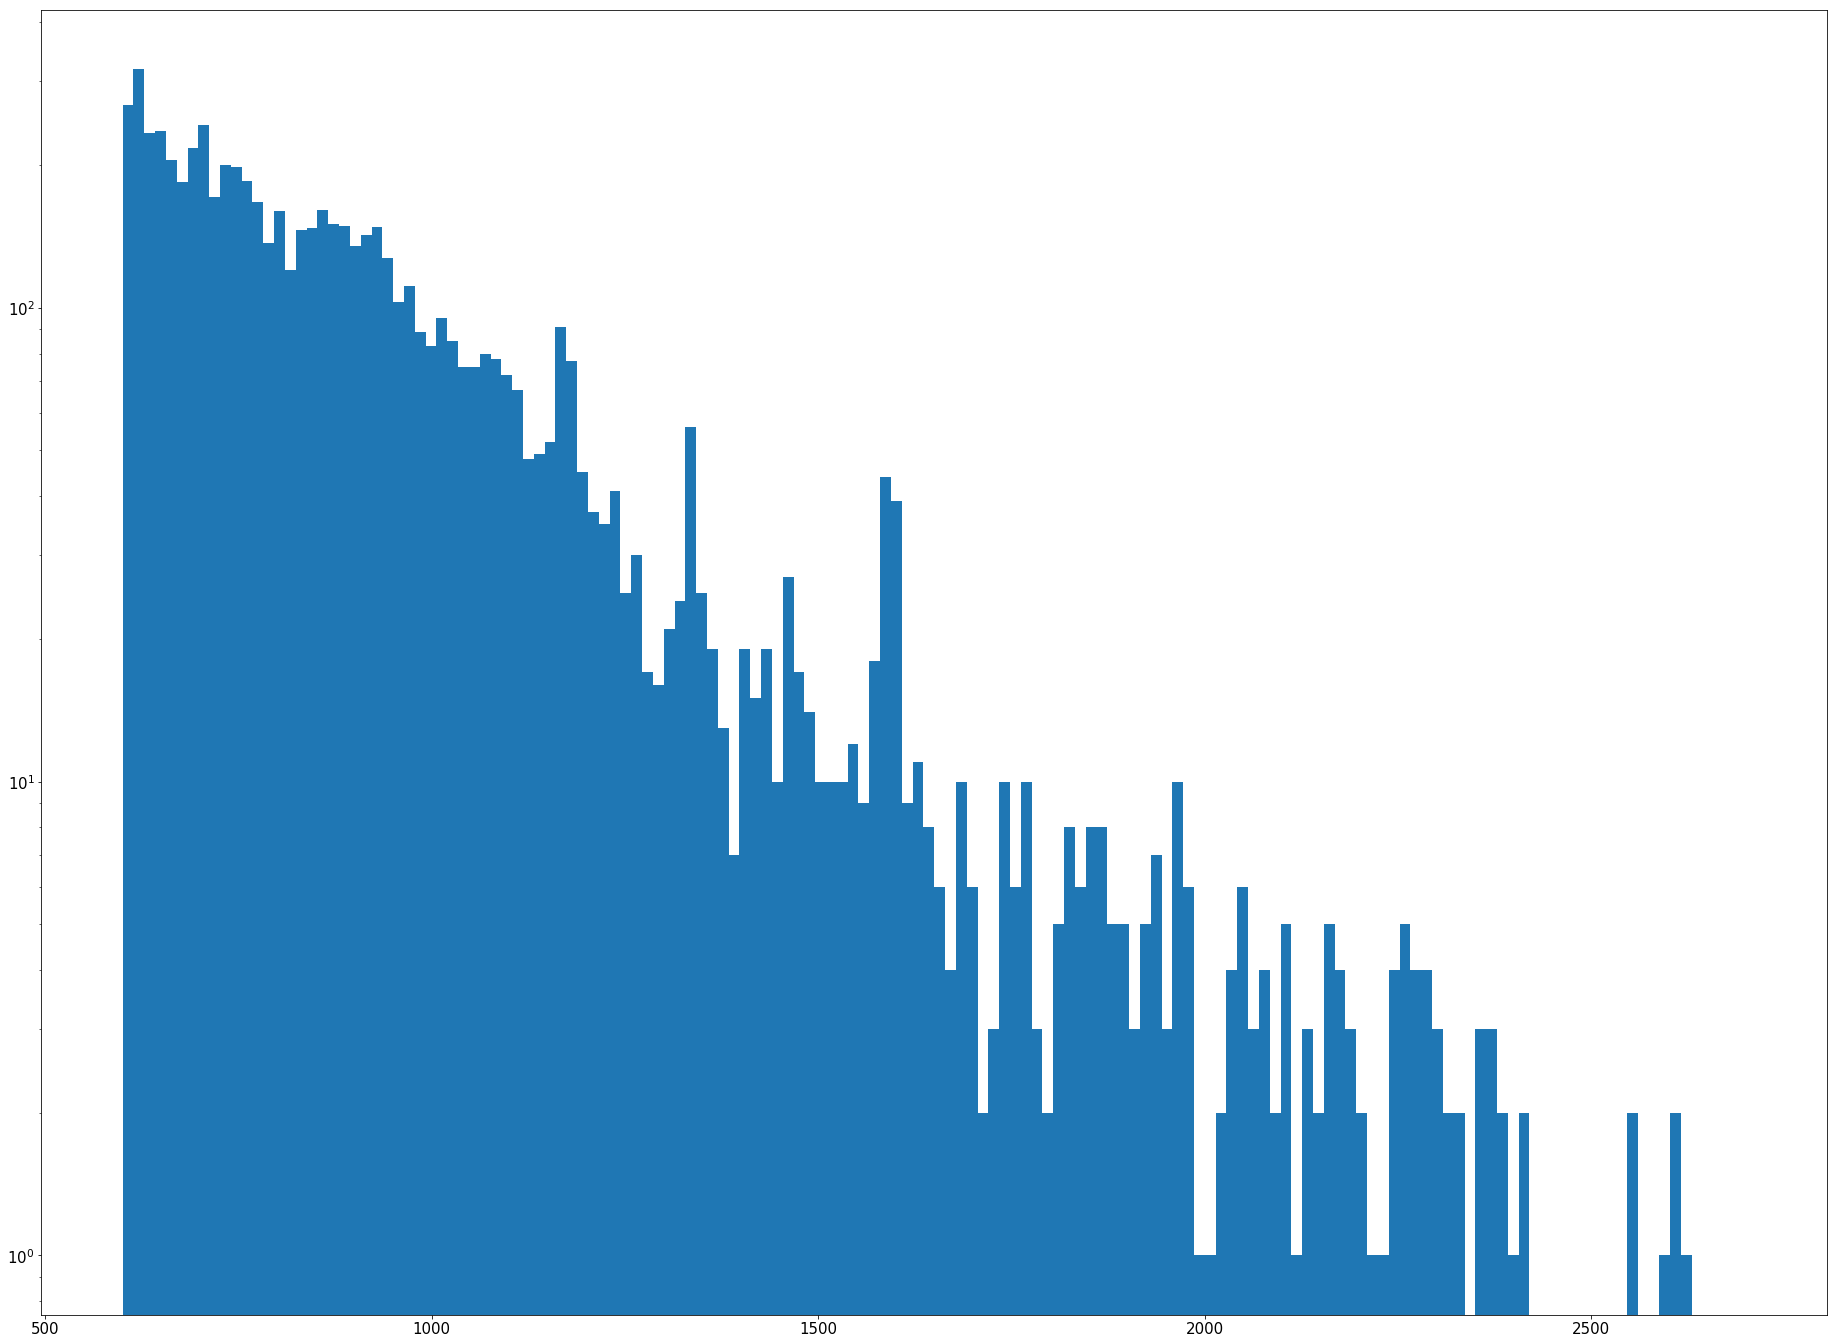

In [15]:
plt.hist(table_data.energy,nbinE,[minE,maxE]);
plt.yscale('log')

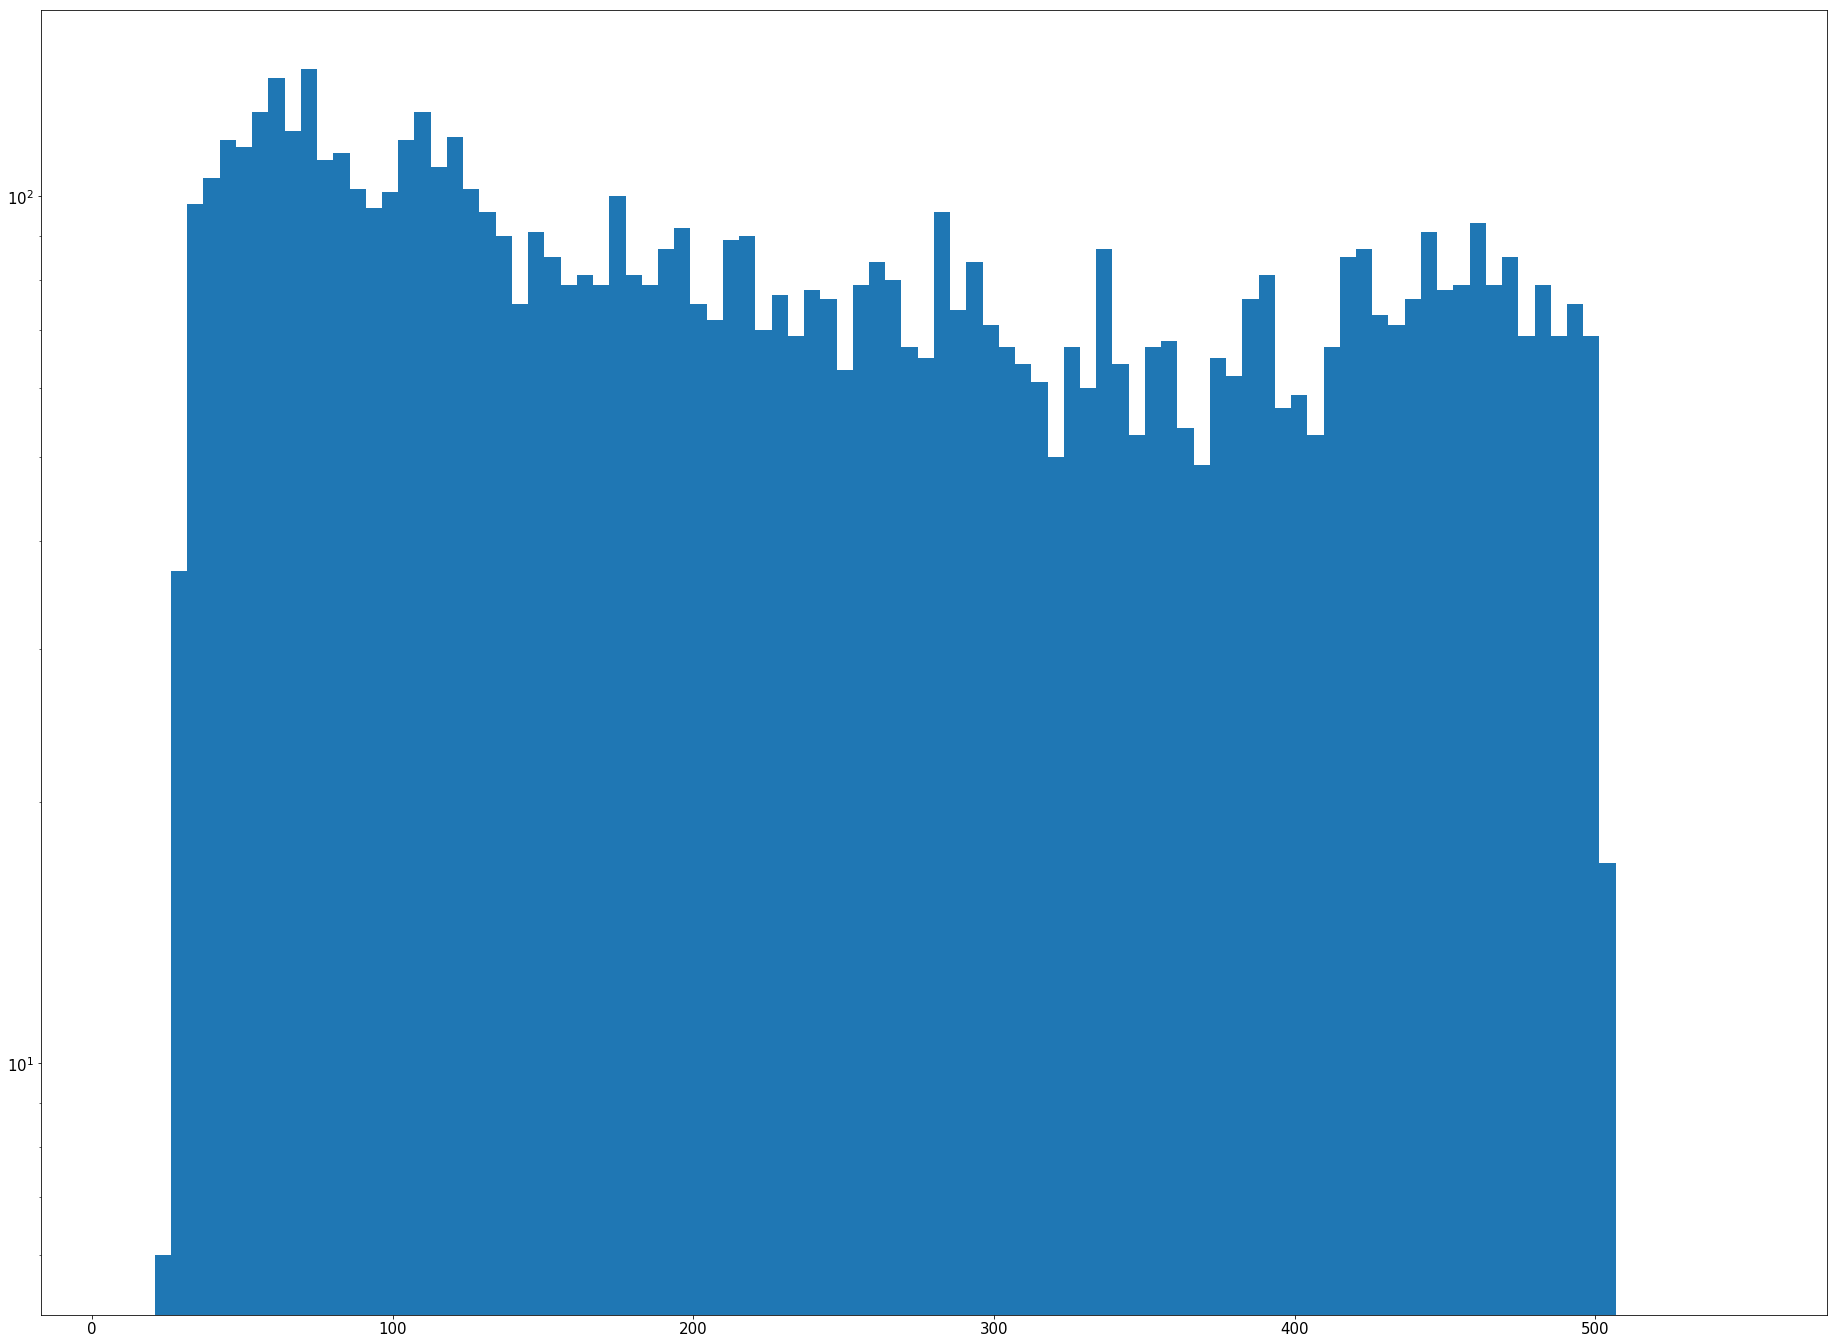

In [16]:
plt.hist(table_data.Zavg,nbinZ,[minZ,maxZ]);
plt.yscale('log')

# Fitting

In [17]:
N_MC  = np.array(N_MC)
N_0MC = 27.167/(5.9*365.24) * N_MC

In [18]:
list( zip( N_MC,N_0MC))

[(39306, 495.5302675371105),
 (2877, 36.27030427172103),
 (12847, 161.96197392380955),
 (15750, 198.56005988168448),
 (23667, 298.36958331554456),
 (55960, 705.4870445066073),
 (37053, 467.1267237330829),
 (15060, 189.86123821067736),
 (4724, 59.55541097657635),
 (17800, 224.40438513612597),
 (3732, 47.049278951012475),
 (8793, 110.85324485966042)]

In [19]:
[[0.1,200]]*len(N_0MC)

[[0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200],
 [0.1, 200]]

In [37]:
fit = Fit(x_dict, totals, pdfs,N_0MC)

In [38]:
totals = {'E': h_total_e    , 'z': h_total_z   }

In [39]:
ratios = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
bounds = [[0  , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000],
          [0. , 200000]]

%time res_ll = fit.FitLLM(ratios,tol=1e-12,options={"maxiter":10000,'ftol':1e-20}, bounds=bounds)
print(res_ll)

CPU times: user 171 ms, sys: 6.13 ms, total: 177 ms
Wall time: 187 ms
    chi2: -1
     err: -1
     fun: 1651.8550488482178
     jac: array([ 89.27863746,   3.94900326,  18.34284831,   8.96434358,
        75.22755823, 121.17764072,  79.67730653,   8.88362592,
        17.10766355,  52.27998372,   9.94853053,   5.33354978])
 message: 'Linear search failed'
    nfev: 156
     nit: 15
  status: 4
 success: False
       x: array([ 2.38380191, 19.94698044,  3.58219408,  2.47991073,  0.        ,
        4.23188046,  1.37529471,  1.36138796,  0.        ,  1.45421225,
        0.        ,  1.14965273])


In [40]:
result    = res_ll.x
factors   = res_ll.x * N_0MC
#factors   = np.array([514.04165853, 514.04179216, 514.04164491, 514.04166726,
#                      514.04167153, 514.0416711 , 514.04166152, 514.04166413,
#                      514.04163411, 514.04167932, 514.04171903, 514.04167595])

pdfs_plot = {'E':[], 'z':[]}

interpol = 'nearest'

pdfs_plot['E'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['E'], range(len(N_0MC)))]
pdfs_plot['z'] = [PDF(h_, factor=factors[i], interpolation=interpol) for h_, i in zip(histograms['z'], range(len(N_0MC)))]


In [41]:
Ep = np.linspace(totals['E'].bins[0],totals['E'].bins[-1],1000)
Zp = np.linspace(totals['z'].bins[0],totals['z'].bins[-1],1000)

y_e = [pdf.pdf(Ep) for pdf in pdfs_plot['E']] 
y_z = [pdf.pdf(Zp) for pdf in pdfs_plot['z']] 


fittotal_e = np.sum(y_e, axis=0)
fittotal_z = np.sum(y_z, axis=0)

anode_e   = y_e[0] + y_e[1] + y_e[2]  + y_e[3]
barrel_e  = y_e[4] + y_e[5] + y_e[6]  + y_e[7]
cathode_e = y_e[8] + y_e[9] + y_e[10] + y_e[11]

anode_z   = y_z[0] + y_z[1] + y_z[2]  + y_z[3]
barrel_z  = y_z[4] + y_z[5] + y_z[6]  + y_z[7]
cathode_z = y_z[8] + y_z[9] + y_z[10] + y_z[11]

K_e  = y_e[0] + y_e[4] + y_e[8] 
Co_e = y_e[1] + y_e[5] + y_e[9]
Bi_e = y_e[2] + y_e[6] + y_e[10]
Tl_e = y_e[3] + y_e[7] + y_e[11] 

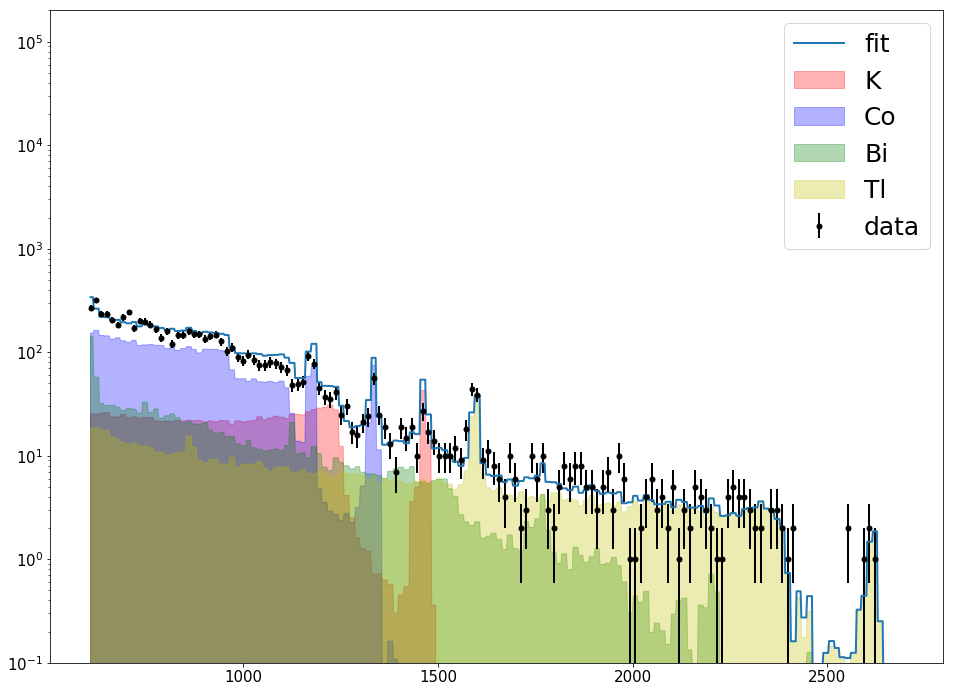

In [83]:
alfa= 0.3
plt.semilogy()
plt.ylim(1e-1,2e5)

plt.errorbar(totals['E'].bins, totals['E'].hist, yerr=np.sqrt(totals['E'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Ep, fittotal_e, label='fit', linewidth=2,)


plt.fill_between(Ep, 0 , K_e  , label='K'  ,alpha=alfa,color='r')
plt.fill_between(Ep, 0 , Co_e , label='Co' ,alpha=alfa,color='b')
plt.fill_between(Ep, 0 , Bi_e , label='Bi' ,alpha=alfa,color='g')
plt.fill_between(Ep, 0 , Tl_e , label='Tl' ,alpha=alfa,color='y')


'''
plt.fill_between(Ep, 0 , fit_0_a_e, label='fit_e_0',alpha=alfa,color='r')
plt.fill_between(Ep, 0 , fit_1_a_e, label='fit_e_1',alpha=alfa,color='b')
plt.fill_between(Ep, 0 , fit_2_a_e, label='fit_e_2',alpha=alfa,color='g')

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend().get_frame().set_facecolor('0.95')
plt.legend(fontsize=25)

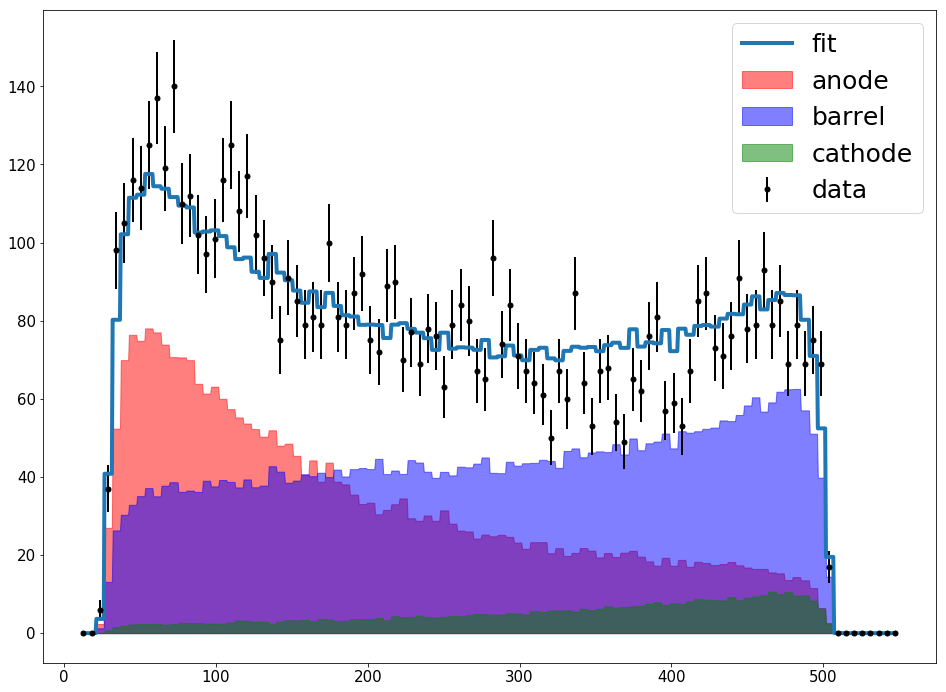

In [84]:
alfa= 0.5


plt.errorbar(totals['z'].bins, totals['z'].hist, yerr=np.sqrt(totals['z'].hist),
             marker='.', markersize=10, elinewidth=2, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z, label='fit', linewidth=4,)

plt.fill_between(Zp, 0 , anode_z  , label='anode'  ,alpha=alfa,color='r')
plt.fill_between(Zp, 0 , barrel_z , label='barrel' ,alpha=alfa,color='b')
plt.fill_between(Zp, 0 , cathode_z, label='cathode',alpha=alfa,color='g')


'''

plt.legend().get_frame().set_facecolor('0.95')


plt.figure()
plt.errorbar(h_total_z.bins, h_total_z.hist, yerr=np.sqrt(h_total_e.hist),
             marker='.', elinewidth=1, linewidth=0,label='data',color='black')

plt.plot(Zp, fittotal_z,label='fit')

plt.fill_between(Zp, 0 , fit_a_0_z, label='fit_z_0',alpha=alfa,color='r')
plt.fill_between(Zp, 0 , fit_a_1_z, label='fit_z_1',alpha=alfa,color='b')
'''
plt.legend(fontsize=25)

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text yticklabel objects>)

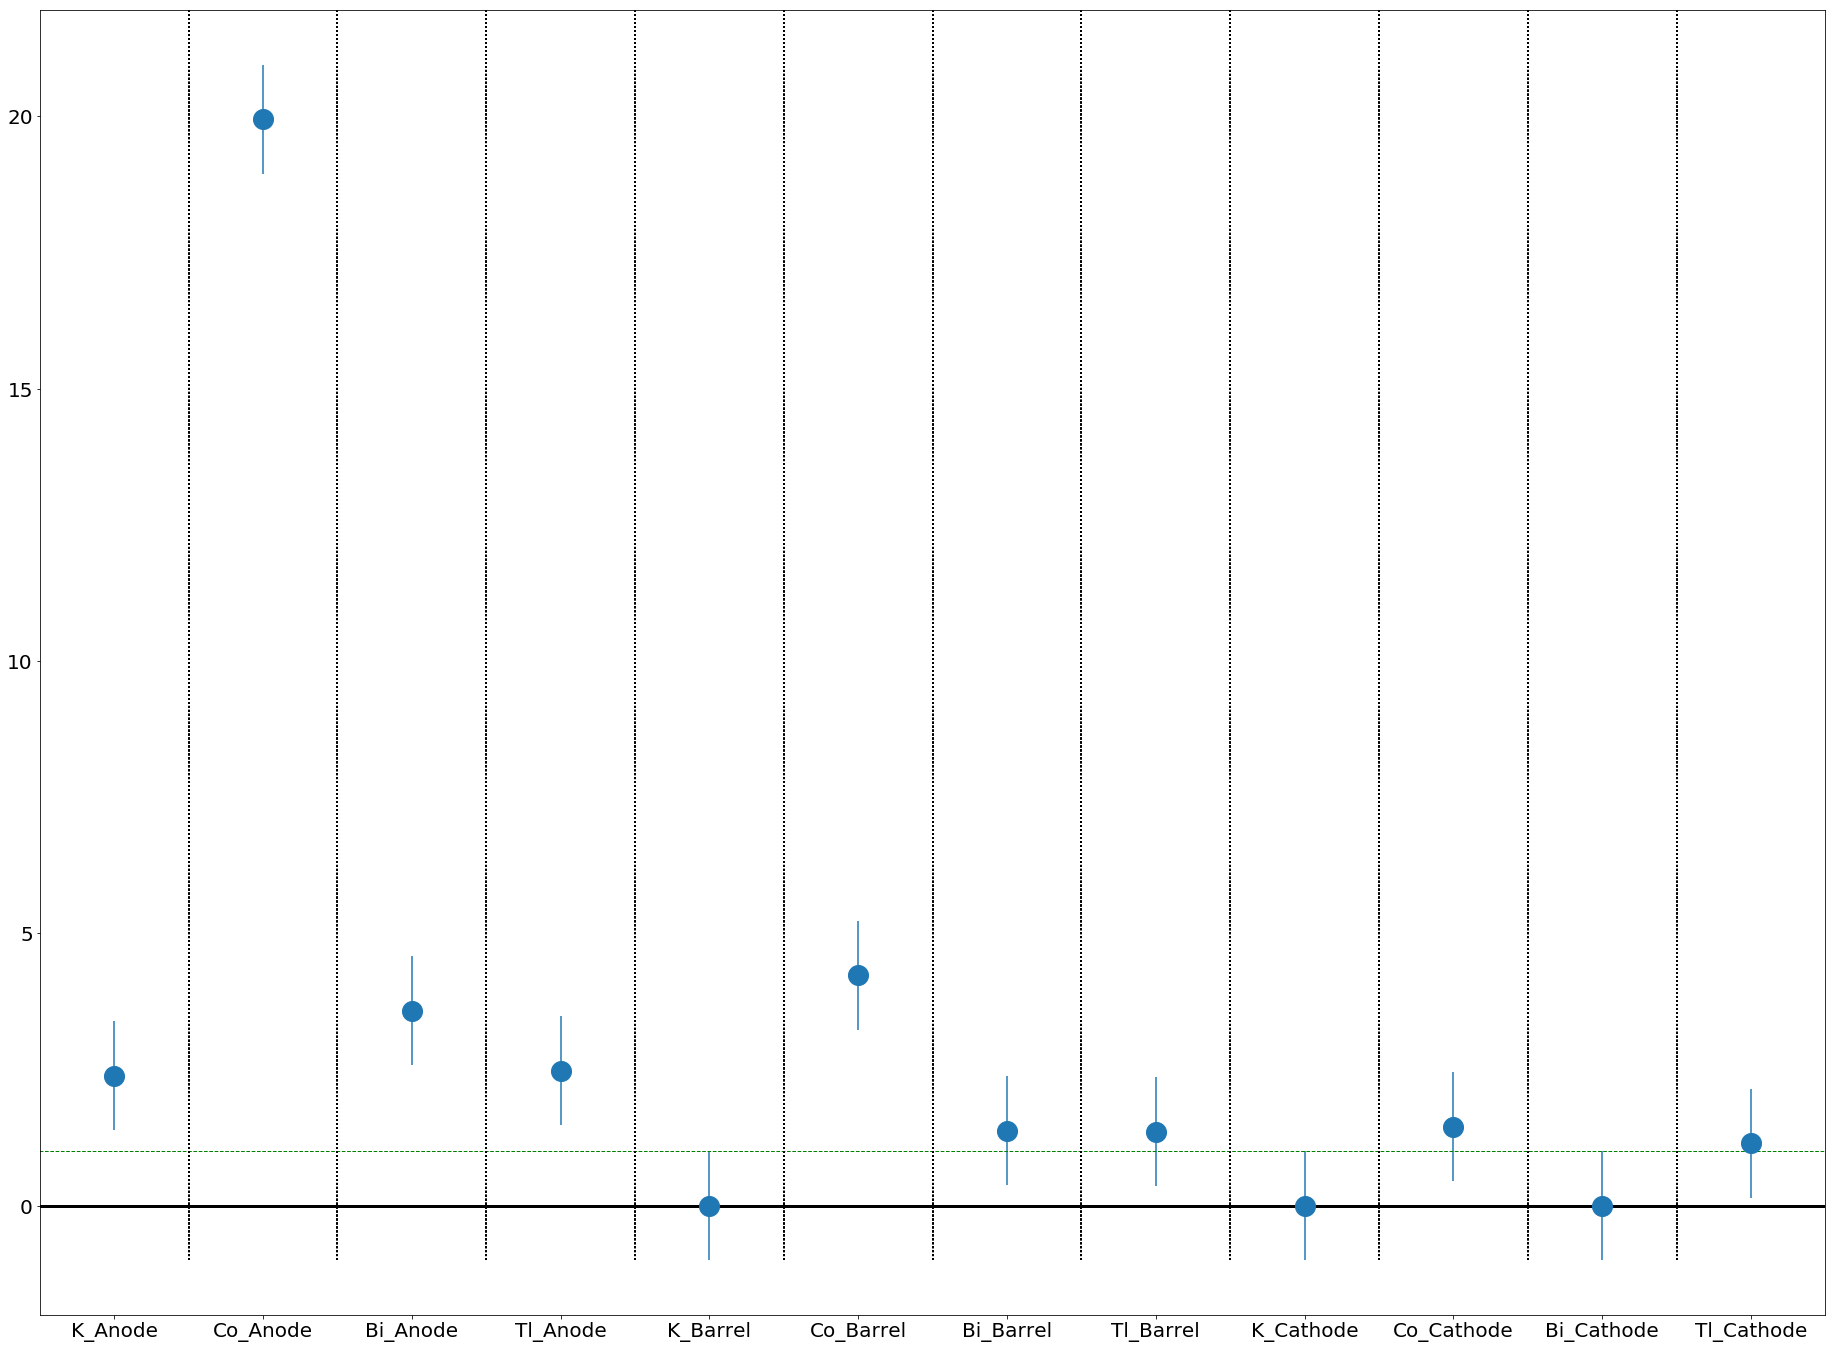

In [78]:
plt.errorbar(range((len(res_ll.x))), res_ll.x, res_ll.err, fmt='.', markersize=40)
plt.hlines(1, -1, 13, linewidth=1, linestyles='dashed', color='g')
plt.hlines(0, -1, 13, linewidth=3)
for i in range(len(res_ll.x)-1):
    plt.vlines(np.arange((len(res_ll.x)-1))+.5, -1, 100,linestyles='dotted')
plt.xlim(-.5,11.5)
plt.ylim(np.min(res_ll.x)-2, np.max(res_ll.x)+2)
plt.xticks(range((len(res_ll.x))),name, fontsize=20);
plt.yticks(fontsize=20)